# 1D Arbitrary Adjoint Notebook

In this notebook, we implement the adjoint idea in a very basic, unelegant manner. But this is the only way to go before we find out more about nutils' inner mechanisms.
Here, we one extra domain for every local adjoint problem to be solved. A union of these domains is supposed to form the total domain. Using a separate domain for each problem allows us to utilize nutils's boundary and interface topology functionality.

We are, however, one step ahead of the SimpleAdjoint version: Instead of being restricted to piecewise linears and a two-element domain, we allow for arbitrary polynomial degrees and element numbers (for 1D).

#### Import statements

In [1]:
from nutils import *
# Import function that helps with the setup of the rectilinear domains
from utils.Meshing.meshingM import feSupport1DRectilinear as support
from utils.Meshing.meshingM import feNrNodes1DRectilinear as nr_nodes_func
import numpy, unittest

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections

#### Setting problem specific parameters

In this notebook, we extend the adjoint implementation to 1D cases of arbitrary dimension and arbitrary element numbers. This requires a more abstract version of the topology setup. The most important variabes here are

1. primalNelems
2. adjointNelems
3. primalDegree
4. adjointDegree
5. primalDG
6. adjointDG

**primalNelems**
>> Number of elements of primal problem topology

**adjointNelems**
>> Gives degree of refinement of primal topology elements. adjointNelems = 1, means that the primal topology elements are also exacly the adjoint problem elements. A value of two, for instance, would split every primal topology element into two elements for the adjoint problem.

**primalDegree**
>> Polynomial degree of intrpolation polynomial for primal trial function.

**adjointDegree**
>> Adjoint degree of interpolation polynomial for the enrichment basis function.

**primalDG**
>> A boolean indicating whether DG discretization is used for the primal formulation

**adjointDG**
>> A boolean indicating whether DG discretization is used for the enrichment basis functions.

In [2]:
primalNelems = 2        # number of elements of complete primal domain
adjointNelems = 10       # number of elements of local adjoint domain
primalDegree = 1        # 
adjointDegree = 1       #
primalDG     = False
adjointDG    = True
if primalDG:
    nr_nodes = nr_nodes_func(primalNelems, primalDegree, 'DG')
else:
    nr_nodes = nr_nodes_func(primalNelems, primalDegree, 'CG')
ndims = 1
lbound = 0              # lower bound of complete primal domain
rbound = 1              # right bound of complete primal domain
span = (rbound - lbound) / primalNelems #
v = 200                 # convective velocity
k = 1                   # diffusivity
meshPeclet = v * span / k
print(meshPeclet)

100.0


#### Create namespace

Put the necessary variables and parameters in a nutils Namespace for easier access

In [3]:
# prepare residual
ns = function.Namespace()
ns.pi = numpy.pi
ns.k = k
ns.v = v
ns.h = span
ns.lbound = lbound
ns.rbound = rbound

#### Stabilization and method choice variables

In this section, the user can adjust some stabilization parameters

> beta and gamma: Setting beta and gamma in different manners corresponds to different methods. beta = 1 and gamma = 0 corresponds to the DG method of Oden, Babuska and Baumann, which is stable for polynomials of degree two and higher. Setting gamma > 0 stabilizes the formulation for linear polynomials and corresponds to the interior penalty collocation method. If you encounter instabilities, study the behaviour for high and zero gammas.

> C determines the strength of the upwinding of the advective DG fluxes. For conservative upwinding, pick C = v (according to Brezzi it is C = v/2, but the 0.5 factor is already included in our implementation.



In [4]:
# Tuning parameters
ns.beta = 1             # beta = 1 creates skew-symmetric bilinear form (more stable in this case)
ns.gamma = 1           # DG stabilization (especially for linear degree)
ns.C = ' v '            # Advection Upwinding coefficient 

# DG Stabilization parameters (all the same for an equidistant mesh)
ns.tauZero = ' gamma k / h'
ns.tauN    = ' gamma k / h'
ns.tauA    = ' gamma k / h'

# SUPG stabilization parameter
if(numpy.exp(v/k) == float('inf')):
    ns.tau = ' h / (2 v)'
else:
    ns.peclet = ' 0.5 v h / k'
    ns.tau = ' ((cosh(peclet) / sinh(peclet)) - (1 / peclet)) h / (2 v) ' 

Boundary conditions and analytical solution

In this section, boundary conditions for the various problems are set. Furthermore, the analytical solution to the primal problem is defined here, in order to enable an evaluation of the success of the method later on.


In [5]:
# Source term for primal problem and BCs for both problems
ns.f = 0
ns.gl = 0
ns.gr = 0

## Analytical solution of primal problem
## Catch potential overflow exceptions
#if(numpy.exp(v/k) == float('inf')):
#    # exp(v/k) -> infinity (triggers overflow exception)
#    # Find expression for ns.g
#    pass
#else:
#    ns.analytical = '( (gr - gl) / (exp(v / k) - 1) ) (exp( (v / k) x_0) - 1) + gl'

# Solution of the adjoint problems

In this section, we actually solve the local adjoint problems. For each node of our primal domain we solve an affiliated adjoint problem.

At first, we take a look at the **primal problem** to be solved and the adjoint problems connected with that. We would like to solve the following primal BVP (an advection-diffusion-equation with a zero RHS):
>> a u,x - ĸ u,xx = 0 on \[ 0, 1\]<br>
>> u(0) = 1 <br>
>> u(1) = 0 <br>

The **associated weak form BVP** for the polynomial trial space V and the polynomial test space W is (V and W are both subspaces of the infinite-dimensional Hilbert Space U). 
> Find u in V such that: 
>> a(u, w) + b(u, w) = l(w) for all w in W

Here, a is a positive definite and symmetric, b is a skew symmetric bilinear form, and l is a linear form on U.
Given a basis {φ} ... (will complete this part later) **Adjoint problems**
> Find φi, i = 1,2, ..., n such that
>> a(u', ψi) + b(u', ψi) + b(u', φi) for all u' in V' 

**IMPORTANT NOTE: We assume the support of the perturbations to match with the support of the corresponding primal basis functions.**

### Arbibtrary node adjoint problem
We start with the adjoint problem corresponding to the leftmost node. Here we solve the system 
> a(ψi, uExti) + b(ψi, uExti) + b(ψi, φi).

Here, pert1 is the actual stabilizing perturbation to be solved for. It is defined as the inner product of ψ1 and the corresponding coefficient vector lhsExt1, i.e.
> uExti = <ψi, lhsExti>. There are some subtleties in here, though.

All we have to do is insert the correct variables into the advective and diffusive parts of our well-known formulation (check, e.g. the notebook_adv_diff_Hughes).

**NOTE: We will have to figure out how to add SUPG stabilization. In order to do this, we have to find the strong form corresponding to the weak adjoint problem**

Unlike before, we allow for arbitrary numbers of (equidistant) elements and arbitrary polynomial degrees. Hence, a more flexible structure than before is of need. We will sketch the procedure below:

## General procedure:

Loop over all primal basis functions (we loop over their indices (requires knowledge of the total amount of basis functions (simple function can do that)).
> 1. Create domain and bases (primal as well as adjoint)
> > Use the same names here for each iteration to reduce memory pressure (activates garbage control on each iteration).
> 2. Solve local adjoint problem
> 3. Save inner product of adjoint basis and solution coefficient vector in perturbation vector for later use (each entry of this vector represents the perturbation of the respective primal basis function.

Proceed in this fashiion for every index of the loop. Once this is done, we can build the optimal basis in order to solve the primal problem.

**PLEASE NOTE that this is just prototype code for small numbers of elements. Hence, performance is not of utmost importance. The approach taken above offers lots of potential for optimizations (element based outer loop instead of basis function based loop, e.g., would help to reuse topos, geoms, and bases). This simplistic approach, however, is coded faster and, on top of that, less prone to errors, as it is extremely explicit. Once performance becomes an issue, profiling and optimization will be conducted. **

**Keep in mind GENERATOR functions (yield) as means of designing efficient generalized functions to be built into nutils.**

0 0.5 1 0
PBS is primalBasis_0
PBS is primalBasis_0,0
test1
test2
testA
testB
test3
test4
test5
test6
test7
Here comes the Jacobian
(4, 4)
[[-20190.     94.      0.      0.]
 [   290.   -292.      0.      0.]
 [     0.      0.    -92.     94.]
 [     0.      0.    290. -20190.]]
[-20148.    148.    -48.    148.]
solve > solver returned with residual 4e-14
test8
[ -1.00018472e+00  -4.86484828e-01  -5.21908842e-01  -1.66100250e-04]
0.0 1.0 2 1
PBS is primalBasis_1
PBS is primalBasis_1,0
test1
test2
testA
testB


/home/slukic/Coding/Python/nutils/nutils/warnings.py:30: NutilsWarning: using explicit inflation; this is usually a bug.
  warnings.warn(message, category, stacklevel=stacklevel)


test3
test4
test5
test6
test7
Here comes the Jacobian
(8, 8)
[[-20190.     94.      0.      0.      0.      0.      0.      0.]
 [   290.   -292.      0.      0.      0.      0.      0.      0.]
 [     0.      0.    -92.     92.      0.      0.      0.      0.]
 [     0.      0.    292.   -292.      0.      0.      0.      0.]
 [     0.      0.      0.      0.    -92.     92.      0.      0.]
 [     0.      0.      0.      0.    292.   -292.      0.      0.]
 [     0.      0.      0.      0.      0.      0.    -92.     94.]
 [     0.      0.      0.      0.      0.      0.    290. -20190.]]
[  48. -148.   48. -148.  -48.  148.  -48.  148.]
solve > solver returned with residual 3e+00
test8
[  1.77225803e-05  -5.06831714e-01   9.63955400e+13   9.63955400e+13
  -9.63955400e+13  -9.63955400e+13  -5.21908842e-01  -1.66100250e-04]
0.5 1.0 1 1
PBS is primalBasis_1
PBS is primalBasis_1,0
test1
test2
testA
testB
test3
test4
test5
test6
test7
Here comes the Jacobian
(4, 4)
[[-20190.     94.     

<Figure size 432x288 with 0 Axes>

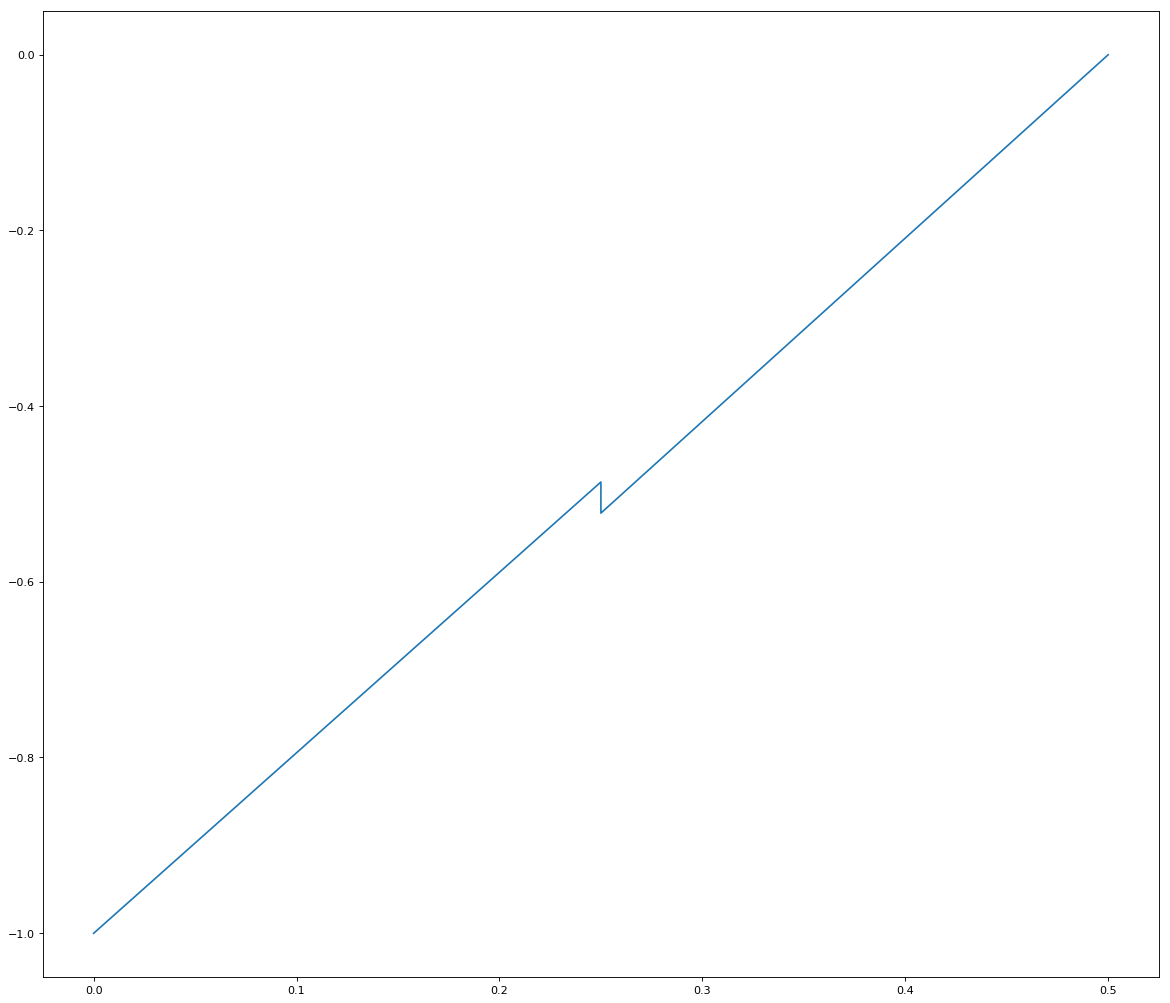

<Figure size 432x288 with 0 Axes>

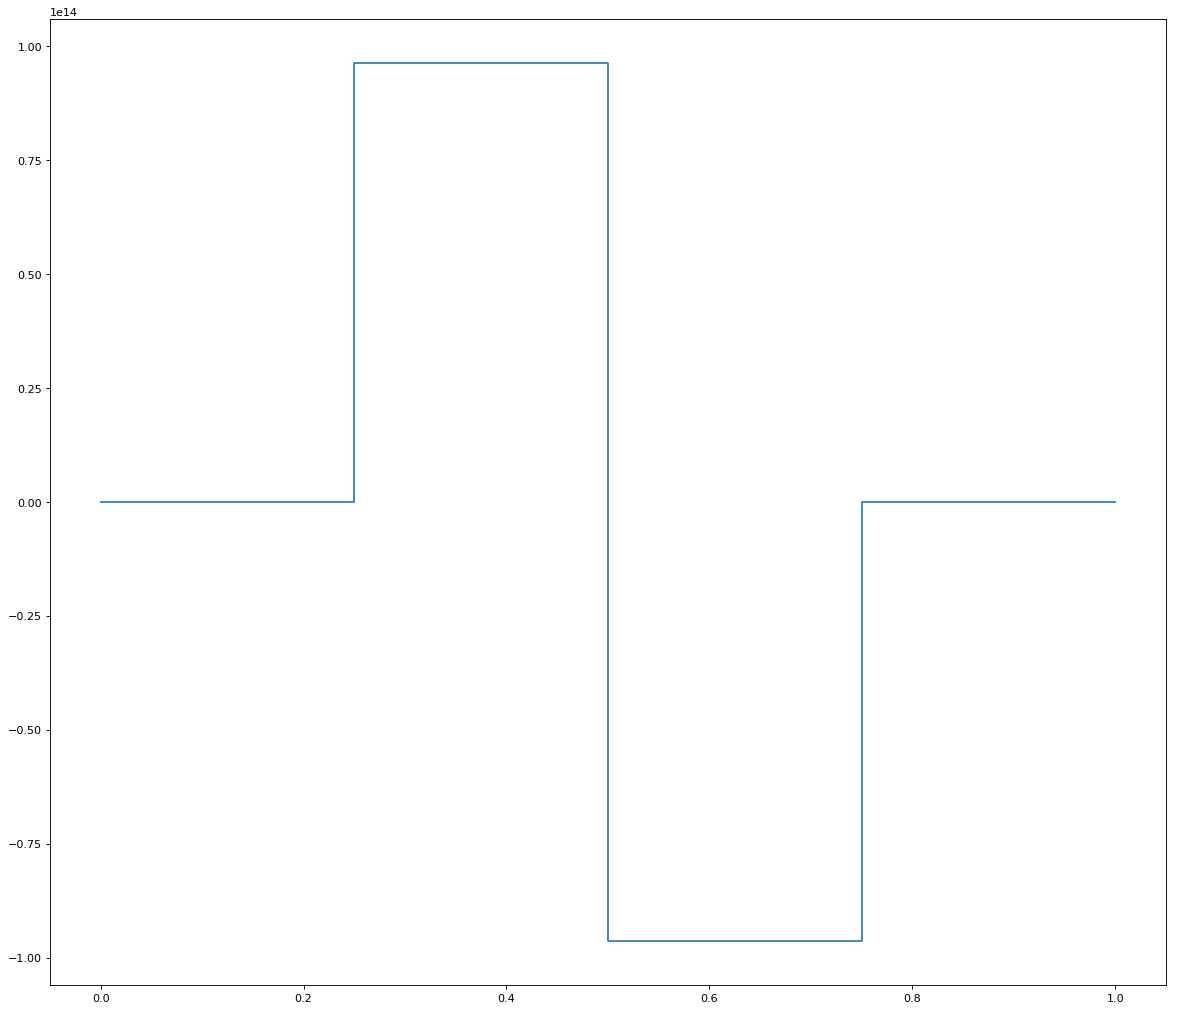

<Figure size 432x288 with 0 Axes>

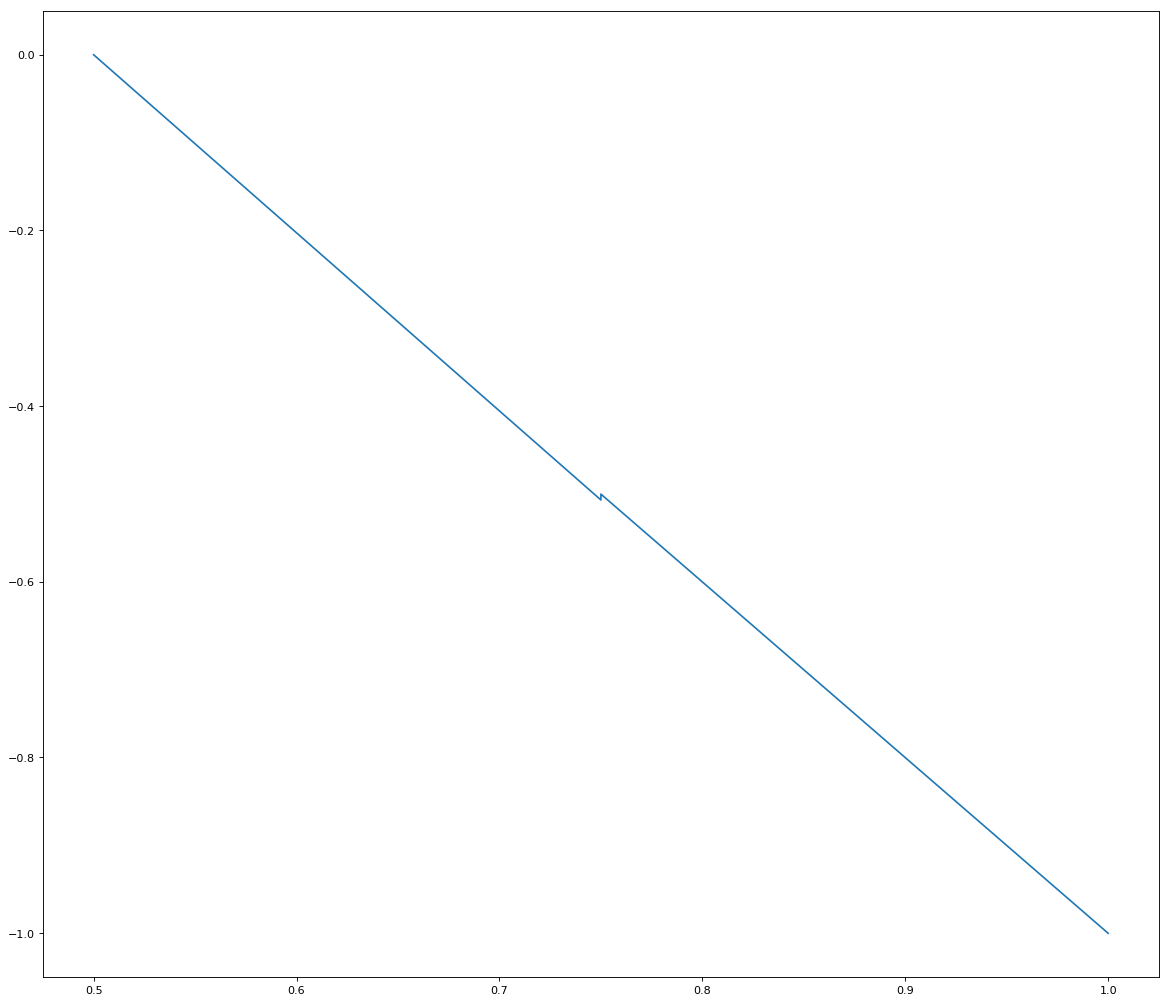

In [6]:
# Loop over all primal basis functions (nodes for FE).
for i in range(0, nr_nodes):
    # Create topology and geometry
    lower, upper, elems, node_nr = support(i, primalDegree, primalNelems, lbound, span)
    print(lower, upper, elems, node_nr)
    localPrimalDomain, localGeom = mesh.rectilinear([numpy.linspace(lower, upper, elems+1)]*ndims)
    localDomain = localPrimalDomain.refined
    # Put geometry in namespace
    ns.x = localGeom
    # Create local bases
    #     Primal
    ns.primalBasis = localPrimalDomain.basis('lagrange', degree=primalDegree)                 # corresponds to phi
    #     Adjoint
    ns.adjointBasis = localDomain.basis('discont', degree=(primalDegree*adjointDegree)) # corresponds to psi
    
    
    # Build adjoint solution function
    ns.uAdj = 'adjointBasis_n ?lhsAdj_n'
    
    # Format primal basis function string (pbs) for integral expressions
    #     without derivative
    pbs    = 'primalBasis_%s'   % (node_nr)
    print('PBS is %s' % pbs)
    pbsDer = 'primalBasis_%s,0' % (node_nr)
    print('PBS is %s' % pbsDer)
    
    ####################################################################
    ###################### construct residual ##########################
    #-------------------------------------------------------------------
    # Element integrals
    # Diffusive part and RHS
    print('test1')
    resAdj = localDomain.integral('k uAdj_,0 adjointBasis_n,0' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    print('test2')
    # Advective part perturbation
    resAdj += localDomain.integral('-v uAdj_,0 adjointBasis_n' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    print('testA')
    # Advective part primal basis
    resAdj += localDomain.integral('-v %s adjointBasis_n' % (pbsDer) @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    print('testB')
    # SUPG stabilized part (will be added later)
    resAdj -= localDomain.integral(' tau v adjointBasis_n,0 (k (uAdj_,0)_,0 + v (uAdj_,0 + %s) )' % (pbsDer) @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    print('test3')
    
    # Interface integrals
#    if (adjointNelems > 1) or (elems > 1):
#        # Diffusive part
#        #    part one                      |
#        #                                  v  minus might be necessary here because of jump definitions (likewise on second +)
#        resAdj += localDomain.interfaces.integral(' [uAdj] n_0 k {adjointBasis_n,0} + beta k {uAdj_,0} [adjointBasis_n] n_0' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
#        #    part two (stabilized)
#        resAdj += localDomain.interfaces.integral(' tauA [uAdj] n_0 [adjointBasis_n] n_0' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
#        # Advective part perturbation
#        resAdj += localDomain.interfaces.integral('- v [uAdj] n_0 ({adjointBasis_n} - .5 C [adjointBasis_n] n_0)' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
#        # Advective part primal basis
#        resAdj += localDomain.interfaces.integral('- v [%s] n_0 ({adjointBasis_n} - .5 C [adjointBasis_n] n_0)' % (pbs) @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
#    else:
#        # No interface integrals
#        pass
        

    # Boundary integrals LHS
    #    part one
    resAdj += localDomain.boundary.integral('- k uAdj adjointBasis_n,0 + beta k uAdj_,0 adjointBasis_n ' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    print('test4')
    #    part two (stabilized)
    resAdj += localDomain.boundary['left'].integral(' tauZero uAdj adjointBasis_n ' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    print('test5')
    resAdj += localDomain.boundary['right'].integral(' tauN uAdj adjointBasis_n ' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)

    # Boundary integrals RHS (weakly imposed boundary conditions) (including stabilization)
    # Diffusive part (keep an eye on the signs)
    resAdj += localDomain.boundary['left'].integral(' ( k adjointBasis_n,0 - tauZero adjointBasis_n) gl ' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    resAdj += localDomain.boundary['right'].integral(' ( k adjointBasis_n,0 - tauN adjointBasis_n) gr ' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    # Advective part perturbation
    resAdj += localDomain.boundary['left'].integral('v adjointBasis_n n_0 (0.5 (gl + uAdj) + .5 C (gl - uAdj) n_0)' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    resAdj += localDomain.boundary['right'].integral('v adjointBasis_n n_0 (0.5 (gr + uAdj) + .5 C (gr - uAdj) n_0)' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    # Advective part primal basis
    resAdj += localDomain.boundary['left'].integral('v adjointBasis_n n_0 (0.5 (gl + %s) + .5 C (gl - %s) n_0)' % (pbs, pbs) @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    resAdj += localDomain.boundary['right'].integral('v adjointBasis_n n_0 (0.5 (gr + %s) + .5 C (gr - %s) n_0)' % (pbs, pbs) @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    print('test6')
    #-------------------------------------------------------------------
    ###################### construct residual ##########################
    ####################################################################
    
    
    # Solve system
    # find lhs such that res == 0 and substitute this lhs in the namespace
    # lhs = solver.solve_linear('lhs', res, constrain=cons)
    print('test7')
    lhsAdj = solver.solve_linear('lhsAdj', resAdj)
    print('test8')
    ns = ns(lhsAdj=lhsAdj)
    print(lhsAdj)
    
    # plot solution
    plt.figure()
    bezier = localDomain.sample('bezier', 9)
    x, uAdj = bezier.eval([ns.x, ns.uAdj])
    #x, analytical = bezier.eval([ns.x, ns.analytical])
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(x, uAdj)
    #plt.plot(x, analytical, 'r')
    # plt.ylim(-2,2)

0 0.5 1 0
PBS is primalBasis_0
PBS is primalBasis_0,0
Here comes the Jacobian
(3, 3)
[[ -1.99260400e+04  -2.58666667e+00   3.26266667e+01]
 [  1.26666667e+02  -1.28000000e+02   1.33333333e+00]
 [  9.53733333e+01   1.30586667e+02  -1.99299600e+04]]
[-20131.33333333     66.66666667    164.66666667]
solve > solver returned with residual 4e-14
[ -1.01024013e+00  -4.78880437e-01   2.90080784e-04]
0.0 1.0 2 1
PBS is primalBasis_1
PBS is primalBasis_1,0


/home/slukic/Coding/Python/nutils/nutils/warnings.py:30: NutilsWarning: using explicit inflation; this is usually a bug.
  warnings.warn(message, category, stacklevel=stacklevel)


Here comes the Jacobian
(6, 6)
[[ -1.99260400e+04  -2.58666667e+00   3.26266667e+01   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.26666667e+02  -1.28000000e+02  -6.66666667e-01  -2.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  9.53733333e+01   1.36586667e+02   2.00660400e+04  -2.02960000e+04
   -2.00000000e+00   0.00000000e+00]
 [  0.00000000e+00  -2.00000000e+00  -2.00960000e+04   2.00699600e+04
   -4.58666667e+00   3.26266667e+01]
 [  0.00000000e+00   0.00000000e+00  -2.00000000e+00   1.32666667e+02
   -1.28000000e+02   1.33333333e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   9.53733333e+01
    1.30586667e+02  -1.99299600e+04]]
[  31.33333333  -66.66666667 -164.66666667  -31.33333333   66.66666667
  164.66666667]
solve > solver returned with residual 4e-12
[ -2.48440300e-05  -4.99710155e-01  -1.01514998e+00  -1.01507352e+00
  -5.15386067e-01   2.77558511e-05]
0.5 1.0 1 1
PBS is primalBasis_1
PBS is primalBasis_1,0
Here comes the Jacobian
(3, 3)
[[ 

<Figure size 432x288 with 0 Axes>

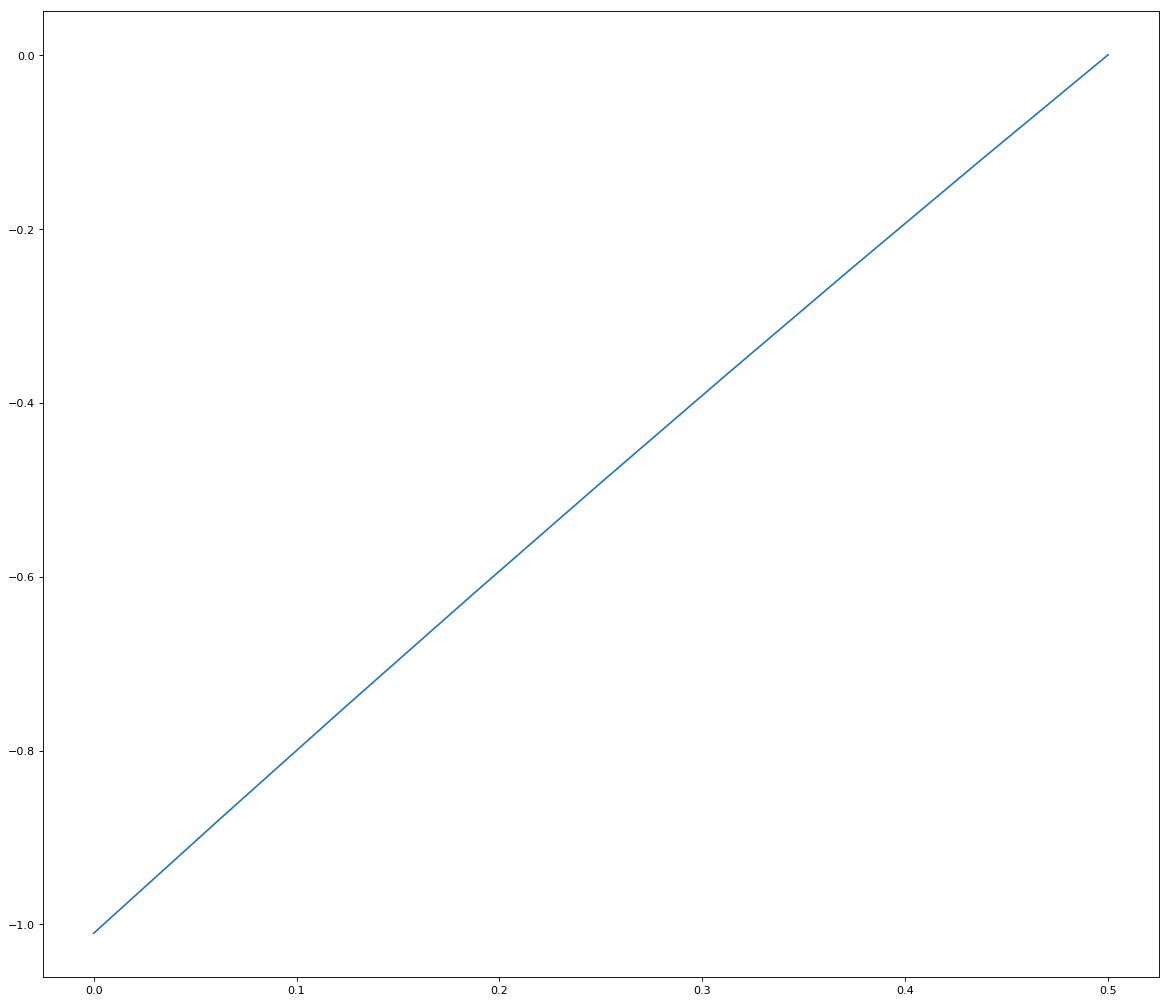

<Figure size 432x288 with 0 Axes>

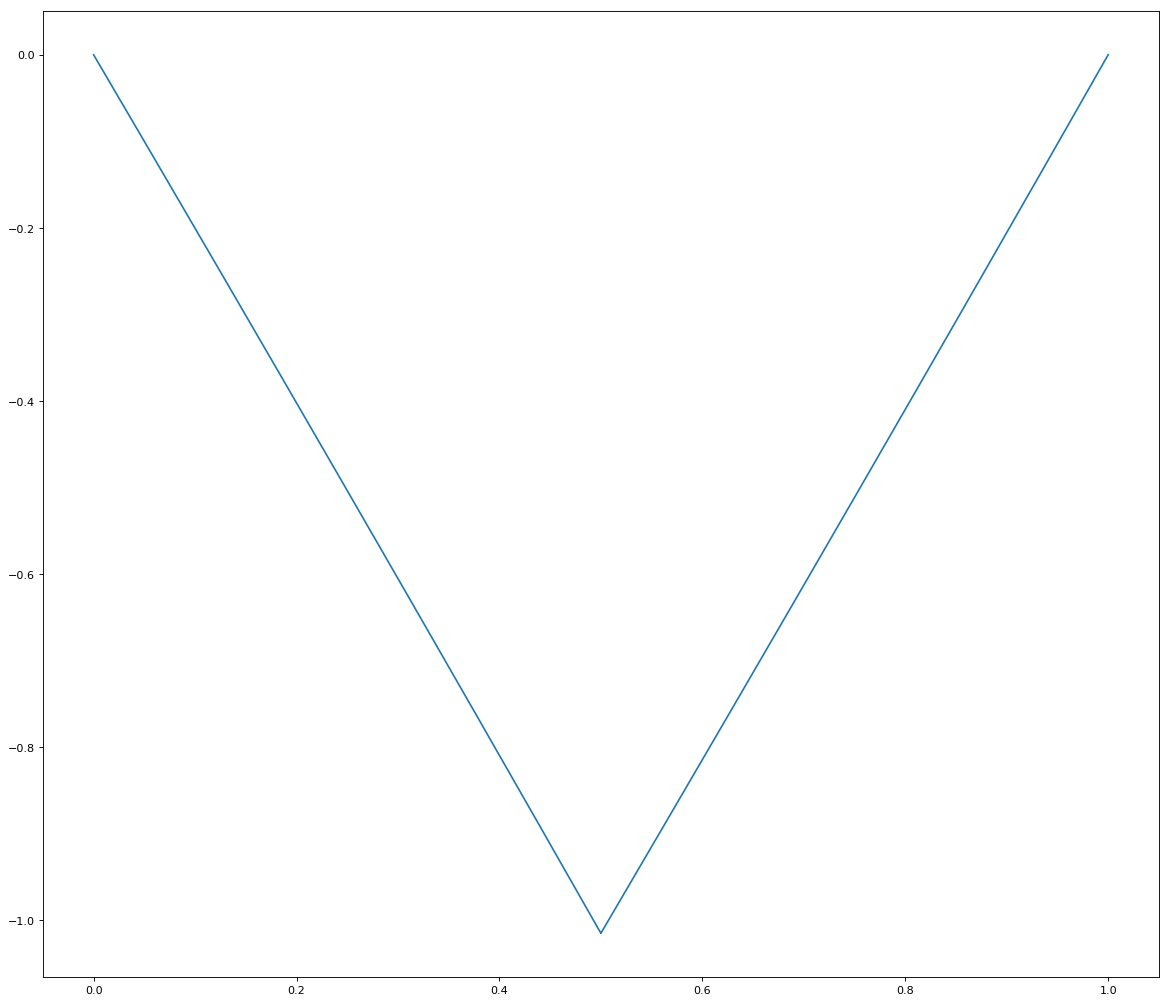

<Figure size 432x288 with 0 Axes>

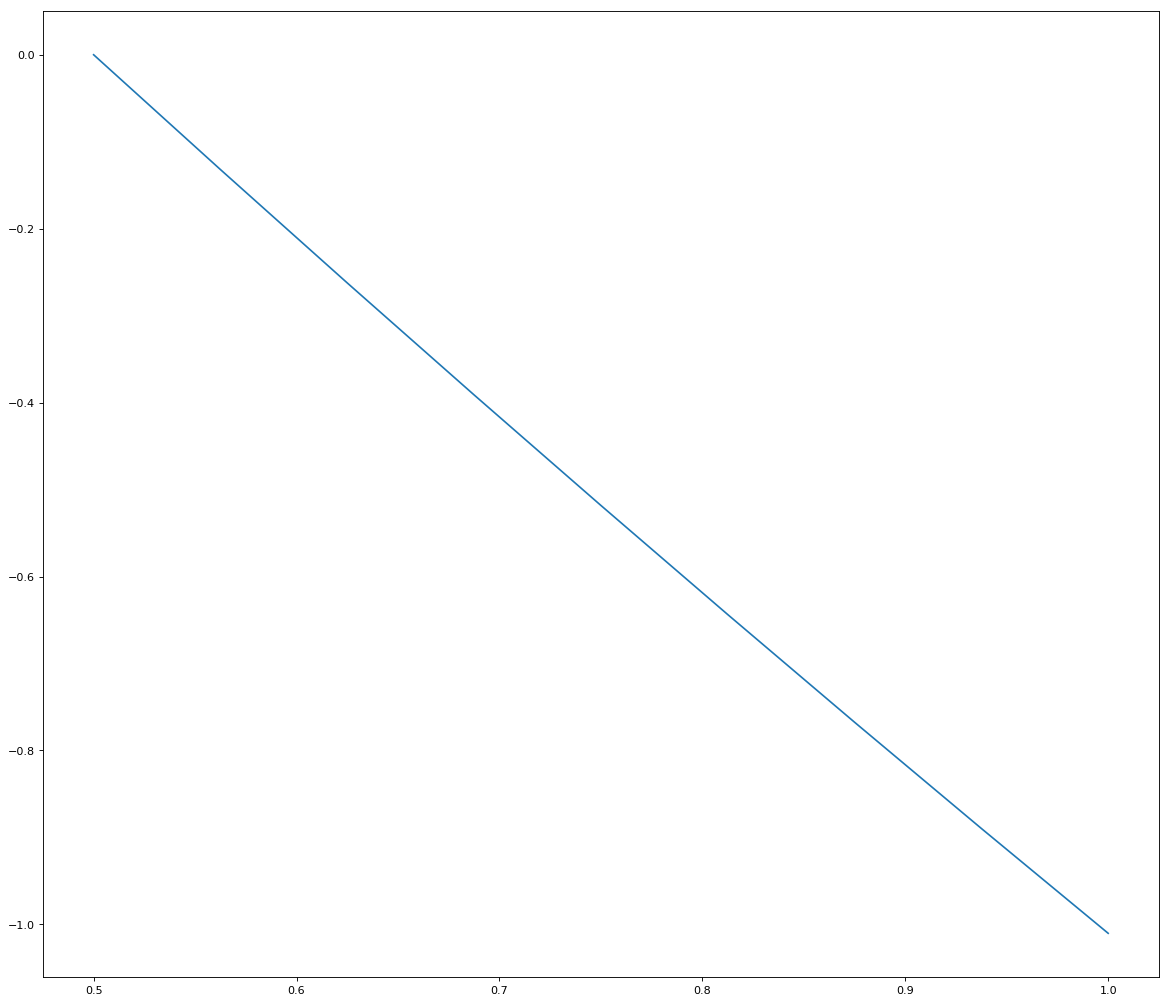

In [7]:
# Loop over all primal basis functions (nodes for FE).
for i in range(0, nr_nodes):
    # Create topology and geometry
    lower, upper, elems, node_nr = support(i, primalDegree, primalNelems, lbound, span)
    print(lower, upper, elems, node_nr)
    localDomain, localGeom = mesh.rectilinear([numpy.linspace(lower, upper, (elems*adjointNelems)+1)]*ndims)
    # Put geometry in namespace
    ns.x = localGeom
    # Create local bases
    #     Primal
    ns.primalBasis = localDomain.basis('lagrange', degree=primalDegree)                 # corresponds to phi
    #     Adjoint
    ns.adjointBasis = localDomain.basis('discont', degree=(primalDegree*adjointDegree)) # corresponds to psi
    
    # Build adjoint solution function
    ns.uAdj = 'adjointBasis_n ?lhsAdj_n'
    
    # Format primal basis function string (pbs) for integral expressions
    #     without derivative
    pbs    = 'primalBasis_%s'   % (node_nr)
    print('PBS is %s' % pbs)
    pbsDer = 'primalBasis_%s,0' % (node_nr)
    print('PBS is %s' % pbsDer)
    
    ####################################################################
    ###################### construct residual ##########################
    #-------------------------------------------------------------------
    # Element integrals
    # Diffusive part and RHS
    resAdj = localDomain.integral('k uAdj_,0 adjointBasis_n,0' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    # Advective part perturbation
    resAdj += localDomain.integral('-v uAdj_,0 adjointBasis_n' @ ns, geometry=ns.x, degree=5)
    # Advective part primal basis
    resAdj += localDomain.integral('-v %s adjointBasis_n' % (pbsDer) @ ns, geometry=ns.x, degree=5)
    # SUPG stabilized part (will be added later)
    resAdj -= localDomain.integral(' tau v adjointBasis_n,0 (k (uAdj_,0)_,0 + v (uAdj_,0 + %s) )' % (pbsDer) @ ns, geometry=ns.x, degree=5)

    # Interface integrals
    if (adjointNelems > 1) or (elems > 1):
        # Diffusive part
        #    part one                      |
        #                                  v  minus might be necessary here because of jump definitions (likewise on second +)
        resAdj += localDomain.interfaces.integral(' [uAdj] n_0 k {adjointBasis_n,0} + beta k {uAdj_,0} [adjointBasis_n] n_0' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
        #    part two (stabilized)
        resAdj += localDomain.interfaces.integral(' tauA [uAdj] n_0 [adjointBasis_n] n_0' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
        # Advective part perturbation
        resAdj += localDomain.interfaces.integral('- v [uAdj] n_0 ({adjointBasis_n} - .5 C [adjointBasis_n] n_0)' @ ns, geometry=ns.x, degree=5)
        # Advective part primal basis
        resAdj += localDomain.interfaces.integral('- v [%s] n_0 ({adjointBasis_n} - .5 C [adjointBasis_n] n_0)' % (pbs) @ ns, geometry=ns.x, degree=5)
    else:
        # No interface integrals
        pass
        

    # Boundary integrals LHS
    #    part one
    resAdj += localDomain.boundary.integral('- k uAdj adjointBasis_n,0 + beta k uAdj_,0 adjointBasis_n ' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    #    part two (stabilized)
    resAdj += localDomain.boundary['left'].integral(' tauZero uAdj adjointBasis_n ' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    resAdj += localDomain.boundary['right'].integral(' tauN uAdj adjointBasis_n ' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)

    # Boundary integrals RHS (weakly imposed boundary conditions) (including stabilization)
    # Diffusive part (keep an eye on the signs)
    resAdj += localDomain.boundary['left'].integral(' ( k adjointBasis_n,0 - tauZero adjointBasis_n) gl ' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    resAdj += localDomain.boundary['right'].integral(' ( k adjointBasis_n,0 - tauN adjointBasis_n) gr ' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    # Advective part perturbation
    resAdj += localDomain.boundary['left'].integral('v adjointBasis_n n_0 (0.5 (gl + uAdj) + .5 C (gl - uAdj) n_0)' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    resAdj += localDomain.boundary['right'].integral('v adjointBasis_n n_0 (0.5 (gr + uAdj) + .5 C (gr - uAdj) n_0)' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    # Advective part primal basis
    resAdj += localDomain.boundary['left'].integral('v adjointBasis_n n_0 (0.5 (gl + %s) + .5 C (gl - %s) n_0)' % (pbs, pbs) @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    resAdj += localDomain.boundary['right'].integral('v adjointBasis_n n_0 (0.5 (gr + %s) + .5 C (gr - %s) n_0)' % (pbs, pbs) @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    
    #-------------------------------------------------------------------
    ###################### construct residual ##########################
    ####################################################################
    
    
    # Solve system
    # find lhs such that res == 0 and substitute this lhs in the namespace
    # lhs = solver.solve_linear('lhs', res, constrain=cons)
    lhsAdj = solver.solve_linear('lhsAdj', resAdj)
    ns = ns(lhsAdj=lhsAdj)
    print(lhsAdj)
    
    # plot solution
    plt.figure()
    bezier = localDomain.sample('bezier', 9)
    x, uAdj = bezier.eval([ns.x, ns.uAdj])
    #x, analytical = bezier.eval([ns.x, ns.analytical])
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(x, uAdj)
    #plt.plot(x, analytical, 'r')
    # plt.ylim(-2,2)

In [ ]:
domainTot, geomTot   = mesh.rectilinear([numpy.linspace(0,extent,nelems+1)]*ndims)             # [0, 1]
domainExt1, geomExt1 = mesh.rectilinear([numpy.linspace(0,extent/2,nelemsExt+1)]*ndims)        # [0, 0.5]
domainExt2, geomExt2 = mesh.rectilinear([numpy.linspace(extent/2,extent,nelemsExt+1)]*ndims)   # [0.5, 1]
domainInt, geomInt   = mesh.rectilinear([numpy.linspace(0,extent,nelemsInt+1)]*ndims)          # [0, 1]

#### Assign geometries and create bases

In this section, we create geometry variables corresponding with every domain. Furthermore, we create bases for every problem to be solved **from scratch** (this is different from the basis slicing approach previously attempted). Every basis is then associated with a discrete solution vector. It is these discrete solution vectors that will eventually build the perturbations for our primal problem.

Note that the **primal** base is **CG** whereas our **perturbation** bases are **DG**.

In [5]:
# Assign names to geometries
ns.x = geomTot

# Create individual bases
ns.basisTot  = domainTot.basis('lagrange', degree=degree)
ns.basisTot0 = domainExt1.basis('lagrange', degree=degree)        # corresponds to phi_1
ns.basisTot1 = domainInt.basis('lagrange', degree=degree)         # corresponds to phi_2
ns.basisTot2 = domainExt2.basis('lagrange', degree=degree)        # corresponds to phi_3
ns.basisExt1 = domainExt1.basis('discont', degree=degree)         # corresponds to ψ1
ns.basisExt2 = domainExt2.basis('discont', degree=degree)         # corresponds to ψ3
ns.basisInt  = domainInt.basis('discont', degree=degree)          # corresponds to ψ2

# Build solution functions
ns.u  = 'basisTot_n ?lhs_n'
ns.uExt1 = 'basisExt1_n ?lhsExt1_n'
ns.uExt2 = 'basisExt2_n ?lhsExt2_n'
ns.uInt  = 'basisInt_n ?lhsInt_n'

In [8]:
# BCs and analytical solution
#ns.z = 2
#ns.gl  = 'cos( z pi x_0 )'
#ns.gr  = 'cos( z pi x_0 )'
#ns.dgl = '-(z pi) sin( z pi x_0 )'
#ns.dgr = '-(z pi) sin( z pi x_0 )'
#ns.ddg = '-(z pi)^2 cos( z pi x_0 )'

#ns.f   = ' - ddg'

# u(x) = [(gr-gl)/(exp(v/k) - 1)] [exp((v/k) x) - 1] + gl
# u'(x)= (v/k)[(gr-gl)/(exp(v/k) - 1] [exp((v/k) x)]
#   with u(0) = gl, u(extent) = gr 

In [9]:
ns.x = geomExt1

In [10]:
# construct residual
# Element integrals
# Diffusive part and RHS
#resExt1 = domainExt1.integral('k uExt1_,0 basisExt1_n,0' @ ns, geometry=ns.x, degree=degree*2)
# Advective part perturbation
#resExt1 += domainExt1.integral('-v uExt1_,0 basisExt1_n' @ ns, geometry=ns.x, degree=5)
    # Advective part perturbation
    #res += domain.integral('-v basis_n,0 u' @ ns, geometry=ns.x, degree=5)
# Advective part primal basis
#resExt1 += domainExt1.integral('-v basisTot_0,0 basisExt1_n' @ ns, geometry=ns.x, degree=5)
    # Advective part primal basis
    #res += domain.integral('-v basis_n,0 u' @ ns, geometry=ns.x, degree=5)
# SUPG stabilized part (will be added later)
#res += domain.integral(' tau v basis_n,0 (v u_,0 - k (u_,0)_,0 - f )' @ ns, geometry=ns.x, degree=5)

# Interface integrals
# Diffusive part
#    part one                      |
#                                  v  minus might be necessary here because of jump definitions (likewise on second +)
#resExt1 += domainExt1.interfaces.integral(' [uExt1] n_0 k {basisExt1_n,0} + beta k {uExt1_,0} [basisExt1_n] n_0' @ ns, geometry=ns.x, degree=degree*2)
    #                                  v  minus might be necessary here because of jump definitions (likewise on second +)
    #res += domain.interfaces.integral(' [basis_n] n_0 k {u_,0} + beta k {basis_n,0} [u] n_0' @ ns, geometry=ns.x, degree=degree*2)
#    part two (stabilized)
#resExt1 += domainExt1.interfaces.integral(' tauA [uExt1] n_0 [basisExt1_n] n_0' @ ns, geometry=ns.x, degree=degree*2)
    #    part two (stabilized)
    #res += domain.interfaces.integral(' tauA [basis_n] n_0 [u] n_0' @ ns, geometry=ns.x, degree=degree*2)
# Advective part perturbation
#resExt1 += domainExt1.interfaces.integral('- v [uExt1] n_0 ({basisExt1_n} - .5 C [basisExt1_n] n_0)' @ ns, geometry=ns.x, degree=5)
    # Advective part perturbation
    #res += domain.interfaces.integral('- v [basis_n] n_0 ({u} - .5 C [u] n_0)' @ ns, geometry=ns.x, degree=5)
# Advective part primal basis
#resExt1 += domainExt1.interfaces.integral('- v [basisTot_0] n_0 ({basisExt1_n} - .5 C [basisExt1_n] n_0)' @ ns, geometry=ns.x, degree=5)
    # Advective part primal basis
    #res += domain.interfaces.integral('- v [basis_n] n_0 ({u} - .5 C [u] n_0)' @ ns, geometry=ns.x, degree=5)

# Boundary integrals LHS
#    part one
#resExt1 += domainExt1.boundary.integral('- k uExt1 basisExt1_n,0 + beta k uExt1_,0 basisExt1_n ' @ ns, geometry=ns.x, degree=degree*2)
    #    part one
    #res += domain.boundary.integral('- k basis_n u_,0 + beta k basis_n,0 u ' @ ns, geometry=ns.x, degree=degree*2)
#    part two (stabilized)
#resExt1 += domainExt1.boundary['left'].integral(' tauZero uExt1 basisExt1_n ' @ ns, geometry=ns.x, degree=degree*2)
#resExt1 += domainExt1.boundary['right'].integral(' tauN uExt1 basisExt1_n ' @ ns, geometry=ns.x, degree=degree*2)
    #    part two (stabilized)
    #res += domain.boundary['left'].integral(' tauZero basis_n u ' @ ns, geometry=ns.x, degree=degree*2)
    #res += domain.boundary['right'].integral(' tauN basis_n u ' @ ns, geometry=ns.x, degree=degree*2)

# Boundary integrals RHS (weakly imposed boundary conditions) (including stabilization)
# Diffusive part (keep an eye on the signs)
#resExt1 += domainExt1.boundary['left'].integral(' ( k basisExt1_n,0 - tauZero basisExt1_n) glExt1 ' @ ns, geometry=ns.x, degree=degree*2)
#resExt1 += domainExt1.boundary['right'].integral(' ( k basisExt1_n,0 - tauN basisExt1_n) glExt1 ' @ ns, geometry=ns.x, degree=degree*2)
    # Diffusive part
    #res -= domain.boundary['left'].integral(' ( beta k basis_n,0 + tauZero basis_n) gl ' @ ns, geometry=ns.x, degree=degree*2)
    #res -= domain.boundary['right'].integral(' ( beta k basis_n,0 + tauN basis_n) gr ' @ ns, geometry=ns.x, degree=degree*2)
# Advective part perturbation
#resExt1 += domainExt1.boundary['left'].integral('v uExt1 n_0 (0.5 (glExt1 + basisExt1_n) - .5 C (glExt1 - basisExt1_n) n_0)' @ ns, geometry=ns.x, degree=degree*2)
#resExt1 += domainExt1.boundary['right'].integral('v uExt1 n_0 (0.5 (grExt1 + basisExt1_n) - .5 C (grExt1 - basisExt1_n) n_0)' @ ns, geometry=ns.x, degree=degree*2)
    # Advective part perturbation
    #res += domain.boundary['left'].integral('v basis_n n_0 (0.5 (gl + u) - .5 C (gl - u) n_0)' @ ns, geometry=ns.x, degree=degree*2)
    #res += domain.boundary['right'].integral('v basis_n n_0 (0.5 (gr + u) - .5 C (gr - u) n_0)' @ ns, geometry=ns.x, degree=degree*2)
# Advective part primal basis
#resExt1 += domainExt1.boundary['left'].integral('v basisTot_0 n_0 (0.5 (glExt1 + basisExt1_n) - .5 C (glExt1 - basisExt1_n) n_0)' @ ns, geometry=ns.x, degree=degree*2)
#resExt1 += domainExt1.boundary['right'].integral('v basisTot_0 n_0 (0.5 (grExt1 + basisExt1_n) - .5 C (grExt1 - basisExt1_n) n_0)' @ ns, geometry=ns.x, degree=degree*2)
    # Advective part primal basis
    #res += domain.boundary['left'].integral('v basis_n n_0 (0.5 (gl + u) - .5 C (gl - u) n_0)' @ ns, geometry=ns.x, degree=degree*2)
    #res += domain.boundary['right'].integral('v basis_n n_0 (0.5 (gr + u) - .5 C (gr - u) n_0)' @ ns, geometry=ns.x, degree=degree*2)

**NOTE**: the cell above and below this text differ only in one respect. In the cell above, we explicitly upwind the new test functions, whereas we explicitly downwind the new unknown. This is of interest when it comes to the boundary integral expressions. Depending on which part we up- or downwind, we impose the weak BCs to different constituents of the system. The cell above applies the BCs weakly to the new test functions (should be pretty useless).

The cell below, however, applies the BCs weakly to the new unknown, which is what we want. The difference between upwinding and downwinding is simply a matter of switching the sign before the upwinding factor C. Note, however, that although the approach in the cell below is intuitively nicer, we might actually cause problems by potentially breaking such things as elliptic regularity (which I do not know too much about).

**Residual for SUPG**: ĸ psi,xx + v(psi,x + phi,x) = 0

In [11]:
# construct residual
# Element integrals
# Diffusive part and RHS
resExt1 = domainExt1.integral('k uExt1_,0 basisExt1_n,0' @ ns, geometry=ns.x, degree=degree*2)
# Advective part perturbation
resExt1 += domainExt1.integral('-v uExt1_,0 basisExt1_n' @ ns, geometry=ns.x, degree=5)
    # Advective part perturbation
    #res += domain.integral('-v basis_n,0 u' @ ns, geometry=ns.x, degree=5)
# Advective part primal basis
resExt1 += domainExt1.integral('-v basisTot0_0,0 basisExt1_n' @ ns, geometry=ns.x, degree=5)
    # Advective part primal basis
    #res += domain.integral('-v basis_n,0 u' @ ns, geometry=ns.x, degree=5)
# SUPG stabilized part (will be added later)
resExt1 -= domainExt1.integral(' tau v basisExt1_n,0 (k (uExt1_,0)_,0 + v (uExt1_,0 + basisTot0_0,0) )' @ ns, geometry=ns.x, degree=5)

# Interface integrals
# Diffusive part
#    part one                      |
#                                  v  minus might be necessary here because of jump definitions (likewise on second +)
#resExt1 += domainExt1.interfaces.integral(' [uExt1] n_0 k {basisExt1_n,0} + beta k {uExt1_,0} [basisExt1_n] n_0' @ ns, geometry=ns.x, degree=degree*2)
    #                                  v  minus might be necessary here because of jump definitions (likewise on second +)
    #res += domain.interfaces.integral(' [basis_n] n_0 k {u_,0} + beta k {basis_n,0} [u] n_0' @ ns, geometry=ns.x, degree=degree*2)
#    part two (stabilized)
#resExt1 += domainExt1.interfaces.integral(' tauA [uExt1] n_0 [basisExt1_n] n_0' @ ns, geometry=ns.x, degree=degree*2)
    #    part two (stabilized)
    #res += domain.interfaces.integral(' tauA [basis_n] n_0 [u] n_0' @ ns, geometry=ns.x, degree=degree*2)
# Advective part perturbation
#resExt1 += domainExt1.interfaces.integral('- v [uExt1] n_0 ({basisExt1_n} - .5 C [basisExt1_n] n_0)' @ ns, geometry=ns.x, degree=5)
    # Advective part perturbation
    #res += domain.interfaces.integral('- v [basis_n] n_0 ({u} - .5 C [u] n_0)' @ ns, geometry=ns.x, degree=5)
# Advective part primal basis
#resExt1 += domainExt1.interfaces.integral('- v [basisTot_0] n_0 ({basisExt1_n} - .5 C [basisExt1_n] n_0)' @ ns, geometry=ns.x, degree=5)
    # Advective part primal basis
    #res += domain.interfaces.integral('- v [basis_n] n_0 ({u} - .5 C [u] n_0)' @ ns, geometry=ns.x, degree=5)

# Boundary integrals LHS
#    part one
resExt1 += domainExt1.boundary.integral('- k uExt1 basisExt1_n,0 + beta k uExt1_,0 basisExt1_n ' @ ns, geometry=ns.x, degree=degree*2)
    #    part one
    #res += domain.boundary.integral('- k basis_n u_,0 + beta k basis_n,0 u ' @ ns, geometry=ns.x, degree=degree*2)
#    part two (stabilized)
resExt1 += domainExt1.boundary['left'].integral(' tauZero uExt1 basisExt1_n ' @ ns, geometry=ns.x, degree=degree*2)
resExt1 += domainExt1.boundary['right'].integral(' tauN uExt1 basisExt1_n ' @ ns, geometry=ns.x, degree=degree*2)
    #    part two (stabilized)
    #res += domain.boundary['left'].integral(' tauZero basis_n u ' @ ns, geometry=ns.x, degree=degree*2)
    #res += domain.boundary['right'].integral(' tauN basis_n u ' @ ns, geometry=ns.x, degree=degree*2)

# Boundary integrals RHS (weakly imposed boundary conditions) (including stabilization)
# Diffusive part (keep an eye on the signs)
resExt1 += domainExt1.boundary['left'].integral(' ( k basisExt1_n,0 - tauZero basisExt1_n) glExt1 ' @ ns, geometry=ns.x, degree=degree*2)
resExt1 += domainExt1.boundary['right'].integral(' ( k basisExt1_n,0 - tauN basisExt1_n) grExt1 ' @ ns, geometry=ns.x, degree=degree*2)
    # Diffusive part
    #res -= domain.boundary['left'].integral(' ( beta k basis_n,0 + tauZero basis_n) gl ' @ ns, geometry=ns.x, degree=degree*2)
    #res -= domain.boundary['right'].integral(' ( beta k basis_n,0 + tauN basis_n) gr ' @ ns, geometry=ns.x, degree=degree*2)
# Advective part perturbation
resExt1 += domainExt1.boundary['left'].integral('v basisExt1_n n_0 (0.5 (glExt1 + uExt1) + .5 C (glExt1 - uExt1) n_0)' @ ns, geometry=ns.x, degree=degree*2)
resExt1 += domainExt1.boundary['right'].integral('v basisExt1_n n_0 (0.5 (grExt1 + uExt1) + .5 C (grExt1 - uExt1) n_0)' @ ns, geometry=ns.x, degree=degree*2)
    # Advective part perturbation
    #res += domain.boundary['left'].integral('v basis_n n_0 (0.5 (gl + u) - .5 C (gl - u) n_0)' @ ns, geometry=ns.x, degree=degree*2)
    #res += domain.boundary['right'].integral('v basis_n n_0 (0.5 (gr + u) - .5 C (gr - u) n_0)' @ ns, geometry=ns.x, degree=degree*2)
# Advective part primal basis
resExt1 += domainExt1.boundary['left'].integral('v basisExt1_n n_0 (0.5 (glExt1 + basisTot0_0) + .5 C (glExt1 - basisTot0_0) n_0)' @ ns, geometry=ns.x, degree=degree*2)
resExt1 += domainExt1.boundary['right'].integral('v basisExt1_n n_0 (0.5 (grExt1 + basisTot0_0) + .5 C (grExt1 - basisTot0_0) n_0)' @ ns, geometry=ns.x, degree=degree*2)
    # Advective part primal basis
    #res += domain.boundary['left'].integral('v basis_n n_0 (0.5 (gl + u) - .5 C (gl - u) n_0)' @ ns, geometry=ns.x, degree=degree*2)
    #res += domain.boundary['right'].integral('v basis_n n_0 (0.5 (gr + u) - .5 C (gr - u) n_0)' @ ns, geometry=ns.x, degree=degree*2)

#### Solving for the unknown

In [12]:
# find lhs such that res == 0 and substitute this lhs in the namespace
# lhs = solver.solve_linear('lhs', res, constrain=cons)
lhsExt1 = solver.solve_linear('lhsExt1', resExt1)
ns = ns(lhsExt1=lhsExt1)

Here comes the Jacobian
(2, 2)
[[ -1.98960000e+04   1.11022302e-14]
 [  1.92000000e+02  -1.98960000e+04]]
[-20098.    198.]
solve > solver returned with residual 4e-12


/home/slukic/Coding/Python/nutils/nutils/warnings.py:30: NutilsWarning: using explicit inflation; this is usually a bug.
  warnings.warn(message, category, stacklevel=stacklevel)


<Figure size 432x288 with 0 Axes>

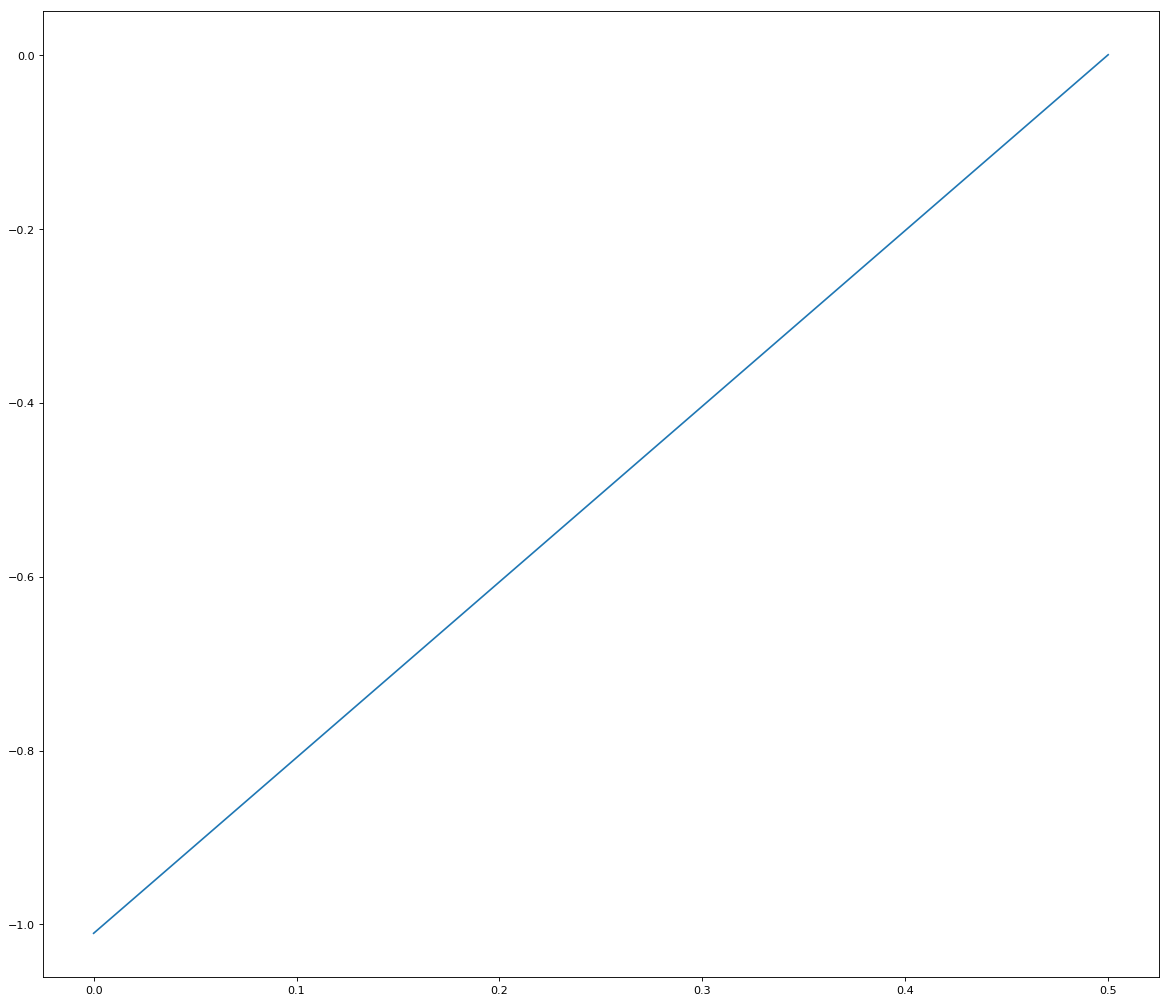

In [13]:
# plot solution
plt.figure()
bezier = domainExt1.sample('bezier', 9)
x, uExt1 = bezier.eval([ns.x, ns.uExt1])
#x, analytical = bezier.eval([ns.x, ns.analytical])
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x, uExt1)
#plt.plot(x, analytical, 'r')
# plt.ylim(-2,2)

#### Internal node adjoint problem

In [14]:
ns.x = geomInt

In [15]:
# construct residual
# Element integrals
# Diffusive part and RHS
resInt = domainInt.integral('k uInt_,0 basisInt_n,0' @ ns, geometry=ns.x, degree=degree*2)
# Advective part perturbation
resInt += domainInt.integral('-v uInt_,0 basisInt_n' @ ns, geometry=ns.x, degree=5)
    # Advective part perturbation
    #res += domain.integral('-v basis_n,0 u' @ ns, geometry=ns.x, degree=5)
# Advective part primal basis
resInt += domainInt.integral('-v basisTot1_1,0 basisInt_n' @ ns, geometry=ns.x, degree=5)
    # Advective part primal basis
    #res += domain.integral('-v basis_n,0 u' @ ns, geometry=ns.x, degree=5)
# SUPG stabilized part (will be added later)
resInt -= domainInt.integral(' tau v basisInt_n,0 (k (uInt_,0)_,0 + v (uInt_,0 + basisTot1_1,0) )' @ ns, geometry=ns.x, degree=5)

# Interface integrals
# Diffusive part
#    part one                      |
#                                  v  minus might be necessary here because of jump definitions (likewise on second +)
resInt += domainInt.interfaces.integral(' [uInt] n_0 k {basisInt_n,0} + beta k {uInt_,0} [basisInt_n] n_0' @ ns, geometry=ns.x, degree=degree*2)
    #                                  v  minus might be necessary here because of jump definitions (likewise on second +)
    #res += domain.interfaces.integral(' [basis_n] n_0 k {u_,0} + beta k {basis_n,0} [u] n_0' @ ns, geometry=ns.x, degree=degree*2)
#    part two (stabilized)
resInt += domainInt.interfaces.integral(' tauA [uInt] n_0 [basisInt_n] n_0' @ ns, geometry=ns.x, degree=degree*2)
    #    part two (stabilized)
    #res += domain.interfaces.integral(' tauA [basis_n] n_0 [u] n_0' @ ns, geometry=ns.x, degree=degree*2)
# Advective part perturbation
resInt += domainInt.interfaces.integral('- v [uInt] n_0 ({basisInt_n} - .5 C [basisInt_n] n_0)' @ ns, geometry=ns.x, degree=5)
    # Advective part perturbation
    #res += domain.interfaces.integral('- v [basis_n] n_0 ({u} - .5 C [u] n_0)' @ ns, geometry=ns.x, degree=5)
# Advective part primal basis
resInt += domainInt.interfaces.integral('- v [basisTot1_1] n_0 ({basisInt_n} - .5 C [basisInt_n] n_0)' @ ns, geometry=ns.x, degree=5)
    # Advective part primal basis
    #res += domain.interfaces.integral('- v [basis_n] n_0 ({u} - .5 C [u] n_0)' @ ns, geometry=ns.x, degree=5)

# Boundary integrals LHS
#    part one
resInt += domainInt.boundary.integral('- k uInt basisInt_n,0 + beta k uInt_,0 basisInt_n ' @ ns, geometry=ns.x, degree=degree*2)
    #    part one
    #res += domain.boundary.integral('- k basis_n u_,0 + beta k basis_n,0 u ' @ ns, geometry=ns.x, degree=degree*2)
#    part two (stabilized)
resInt += domainInt.boundary['left'].integral(' tauZero uInt basisInt_n ' @ ns, geometry=ns.x, degree=degree*2)
resInt += domainInt.boundary['right'].integral(' tauN uInt basisInt_n ' @ ns, geometry=ns.x, degree=degree*2)
    #    part two (stabilized)
    #res += domain.boundary['left'].integral(' tauZero basis_n u ' @ ns, geometry=ns.x, degree=degree*2)
    #res += domain.boundary['right'].integral(' tauN basis_n u ' @ ns, geometry=ns.x, degree=degree*2)

# Boundary integrals RHS (weakly imposed boundary conditions) (including stabilization)
# Diffusive part (keep an eye on the signs)
resInt += domainInt.boundary['left'].integral(' ( k basisInt_n,0 - tauZero basisInt_n) glInt ' @ ns, geometry=ns.x, degree=degree*2)
resInt += domainInt.boundary['right'].integral(' ( k basisInt_n,0 - tauN basisInt_n) glInt ' @ ns, geometry=ns.x, degree=degree*2)
    # Diffusive part
    #res -= domain.boundary['left'].integral(' ( beta k basis_n,0 + tauZero basis_n) gl ' @ ns, geometry=ns.x, degree=degree*2)
    #res -= domain.boundary['right'].integral(' ( beta k basis_n,0 + tauN basis_n) gr ' @ ns, geometry=ns.x, degree=degree*2)
# Advective part perturbation
resInt += domainInt.boundary['left'].integral('v basisInt_n n_0 (0.5 (glInt + uInt) + .5 C (glInt - uInt) n_0)' @ ns, geometry=ns.x, degree=degree*2)
resInt += domainInt.boundary['right'].integral('v basisInt_n n_0 (0.5 (grInt + uInt) + .5 C (grInt - uInt) n_0)' @ ns, geometry=ns.x, degree=degree*2)
    # Advective part perturbation
    #res += domain.boundary['left'].integral('v basis_n n_0 (0.5 (gl + u) - .5 C (gl - u) n_0)' @ ns, geometry=ns.x, degree=degree*2)
    #res += domain.boundary['right'].integral('v basis_n n_0 (0.5 (gr + u) - .5 C (gr - u) n_0)' @ ns, geometry=ns.x, degree=degree*2)
# Advective part primal basis
resInt += domainInt.boundary['left'].integral('v basisInt_n n_0 (0.5 (glInt + basisTot1_1) + .5 C (glInt - basisTot1_1) n_0)' @ ns, geometry=ns.x, degree=degree*2)
resInt += domainInt.boundary['right'].integral('v basisInt_n n_0 (0.5 (grInt + basisTot1_1) + .5 C (grInt - basisTot1_1) n_0)' @ ns, geometry=ns.x, degree=degree*2)
    # Advective part primal basis
    #res += domain.boundary['left'].integral('v basis_n n_0 (0.5 (gl + u) - .5 C (gl - u) n_0)' @ ns, geometry=ns.x, degree=degree*2)
    #res += domain.boundary['right'].integral('v basis_n n_0 (0.5 (gr + u) - .5 C (gr - u) n_0)' @ ns, geometry=ns.x, degree=degree*2)

In [16]:
# find lhs such that res == 0 and substitute this lhs in the namespace
# lhs = solver.solve_linear('lhs', res, constrain=cons)
lhsInt = solver.solve_linear('lhsInt', resInt)
ns = ns(lhsInt=lhsInt)

Here comes the Jacobian
(4, 4)
[[ -1.98960000e+04  -1.00000000e+00  -1.00000000e+00   0.00000000e+00]
 [  1.95000000e+02   2.01020000e+04  -2.02980000e+04  -1.00000000e+00]
 [ -1.00000000e+00  -2.00980000e+04   2.01020000e+04  -1.00000000e+00]
 [  0.00000000e+00  -1.00000000e+00   1.95000000e+02  -1.98960000e+04]]
[  -2. -198.    2.  198.]
solve > solver returned with residual 4e-12


/home/slukic/Coding/Python/nutils/nutils/warnings.py:30: NutilsWarning: using explicit inflation; this is usually a bug.
  warnings.warn(message, category, stacklevel=stacklevel)


<Figure size 432x288 with 0 Axes>

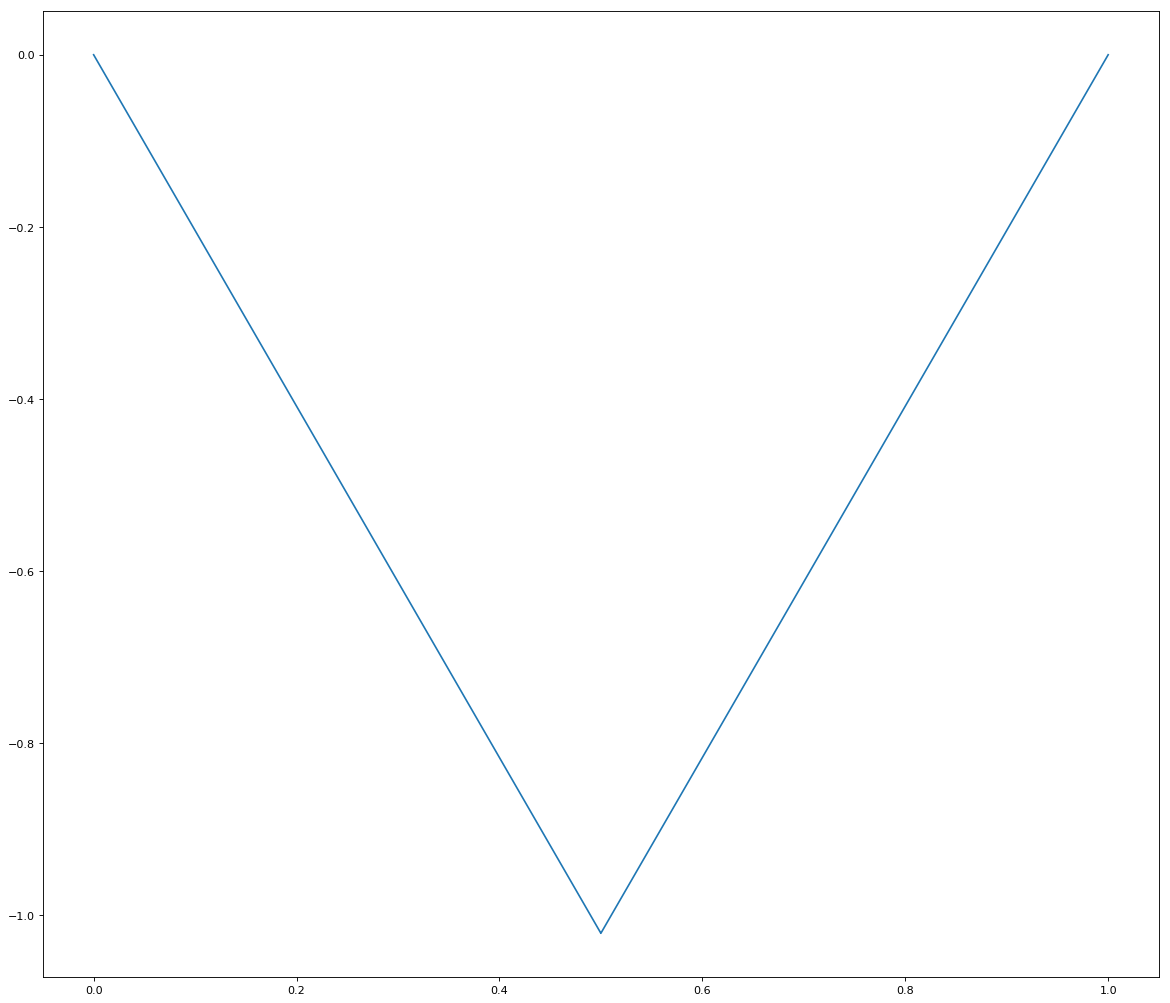

In [17]:
# plot solution
plt.figure()
bezier = domainInt.sample('bezier', 9)
x, uInt = bezier.eval([ns.x, ns.uInt])
#x, analytical = bezier.eval([ns.x, ns.analytical])
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x, uInt)
#plt.plot(x, analytical, 'r')
# plt.ylim(-2,2)


#### Right exterior node adjoint problem

In [18]:
ns.x = geomExt2

In [19]:
# construct residual
# Element integrals
# Diffusive part and RHS
resExt2 = domainExt2.integral('k uExt2_,0 basisExt2_n,0' @ ns, geometry=ns.x, degree=degree*2)
# Advective part perturbation
resExt2 += domainExt2.integral('-v uExt2_,0 basisExt2_n' @ ns, geometry=ns.x, degree=5)
    # Advective part perturbation
    #res += domain.integral('-v basis_n,0 u' @ ns, geometry=ns.x, degree=5)
# Advective part primal basis
resExt2 += domainExt2.integral('- v basisTot2_1,0 basisExt2_n' @ ns, geometry=ns.x, degree=5)
    # Advective part primal basis
    #res += domain.integral('-v basis_n,0 u' @ ns, geometry=ns.x, degree=5)
# SUPG stabilized part (will be added later)
resExt2 -= domainExt2.integral(' tau v basisExt2_n,0 (k (uExt2_,0)_,0 + v (uExt2_,0 + basisTot2_1,0) )' @ ns, geometry=ns.x, degree=5)

# Interface integrals
# Diffusive part
#    part one                      |
#                                  v  minus might be necessary here because of jump definitions (likewise on second +)
#resExt1 += domainExt1.interfaces.integral(' [uExt1] n_0 k {basisExt1_n,0} + beta k {uExt1_,0} [basisExt1_n] n_0' @ ns, geometry=ns.x, degree=degree*2)
    #                                  v  minus might be necessary here because of jump definitions (likewise on second +)
    #res += domain.interfaces.integral(' [basis_n] n_0 k {u_,0} + beta k {basis_n,0} [u] n_0' @ ns, geometry=ns.x, degree=degree*2)
#    part two (stabilized)
#resExt1 += domainExt1.interfaces.integral(' tauA [uExt1] n_0 [basisExt1_n] n_0' @ ns, geometry=ns.x, degree=degree*2)
    #    part two (stabilized)
    #res += domain.interfaces.integral(' tauA [basis_n] n_0 [u] n_0' @ ns, geometry=ns.x, degree=degree*2)
# Advective part perturbation
#resExt1 += domainExt1.interfaces.integral('- v [uExt1] n_0 ({basisExt1_n} - .5 C [basisExt1_n] n_0)' @ ns, geometry=ns.x, degree=5)
    # Advective part perturbation
    #res += domain.interfaces.integral('- v [basis_n] n_0 ({u} - .5 C [u] n_0)' @ ns, geometry=ns.x, degree=5)
# Advective part primal basis
#resExt1 += domainExt1.interfaces.integral('- v [basisTot_0] n_0 ({basisExt1_n} - .5 C [basisExt1_n] n_0)' @ ns, geometry=ns.x, degree=5)
    # Advective part primal basis
    #res += domain.interfaces.integral('- v [basis_n] n_0 ({u} - .5 C [u] n_0)' @ ns, geometry=ns.x, degree=5)

# Boundary integrals LHS
#    part one
resExt2 += domainExt2.boundary.integral('- k uExt2 basisExt2_n,0 + beta k uExt2_,0 basisExt2_n ' @ ns, geometry=ns.x, degree=degree*2)
    #    part one
    #res += domain.boundary.integral('- k basis_n u_,0 + beta k basis_n,0 u ' @ ns, geometry=ns.x, degree=degree*2)
#    part two (stabilized)
resExt2 += domainExt2.boundary['left'].integral(' tauZero uExt2 basisExt2_n ' @ ns, geometry=ns.x, degree=degree*2)
resExt2 += domainExt2.boundary['right'].integral(' tauN uExt2 basisExt2_n ' @ ns, geometry=ns.x, degree=degree*2)
    #    part two (stabilized)
    #res += domain.boundary['left'].integral(' tauZero basis_n u ' @ ns, geometry=ns.x, degree=degree*2)
    #res += domain.boundary['right'].integral(' tauN basis_n u ' @ ns, geometry=ns.x, degree=degree*2)

# Boundary integrals RHS (weakly imposed boundary conditions) (including stabilization)
# Diffusive part (keep an eye on the signs)
resExt2 += domainExt2.boundary['left'].integral(' ( k basisExt2_n,0 - tauZero basisExt2_n) glExt2 ' @ ns, geometry=ns.x, degree=degree*2)
resExt2 += domainExt2.boundary['right'].integral(' ( k basisExt2_n,0 - tauN basisExt2_n) glExt2 ' @ ns, geometry=ns.x, degree=degree*2)
    # Diffusive part
    #res -= domain.boundary['left'].integral(' ( beta k basis_n,0 + tauZero basis_n) gl ' @ ns, geometry=ns.x, degree=degree*2)
    #res -= domain.boundary['right'].integral(' ( beta k basis_n,0 + tauN basis_n) gr ' @ ns, geometry=ns.x, degree=degree*2)
# Advective part perturbation
resExt2 += domainExt2.boundary['left'].integral('v basisExt2_n n_0 (0.5 (glExt2 + uExt2) + .5 C (glExt2 - uExt2) n_0)' @ ns, geometry=ns.x, degree=degree*2)
resExt2 += domainExt2.boundary['right'].integral('v basisExt2_n n_0 (0.5 (grExt2 + uExt2) + .5 C (grExt2 - uExt2) n_0)' @ ns, geometry=ns.x, degree=degree*2)
    # Advective part perturbation
    #res += domain.boundary['left'].integral('v basis_n n_0 (0.5 (gl + u) - .5 C (gl - u) n_0)' @ ns, geometry=ns.x, degree=degree*2)
    #res += domain.boundary['right'].integral('v basis_n n_0 (0.5 (gr + u) - .5 C (gr - u) n_0)' @ ns, geometry=ns.x, degree=degree*2)
# Advective part primal basis
resExt2 += domainExt2.boundary['left'].integral('v basisExt2_n n_0 (0.5 (glExt2 + basisTot2_1) + .5 C (glExt2 - basisTot2_1) n_0)' @ ns, geometry=ns.x, degree=degree*2)
resExt2 += domainExt2.boundary['right'].integral('v basisExt2_n n_0 (0.5 (grExt2 + basisTot2_1) + .5 C (grExt2 - basisTot2_1) n_0)' @ ns, geometry=ns.x, degree=degree*2)
    # Advective part primal basis
    #res += domain.boundary['left'].integral('v basis_n n_0 (0.5 (gl + u) - .5 C (gl - u) n_0)' @ ns, geometry=ns.x, degree=degree*2)
    #res += domain.boundary['right'].integral('v basis_n n_0 (0.5 (gr + u) - .5 C (gr - u) n_0)' @ ns, geometry=ns.x, degree=degree*2)

In [20]:
# find lhs such that res == 0 and substitute this lhs in the namespace
# lhs = solver.solve_linear('lhs', res, constrain=cons)
lhsExt2 = solver.solve_linear('lhsExt2', resExt2)
ns = ns(lhsExt2=lhsExt2)

Here comes the Jacobian
(2, 2)
[[ -1.98960000e+04   1.11022302e-14]
 [  1.92000000e+02  -1.98960000e+04]]
[ -2.00000000e+00  -2.00980000e+04]
solve > solver returned with residual 2e-16


/home/slukic/Coding/Python/nutils/nutils/warnings.py:30: NutilsWarning: using explicit inflation; this is usually a bug.
  warnings.warn(message, category, stacklevel=stacklevel)


<Figure size 432x288 with 0 Axes>

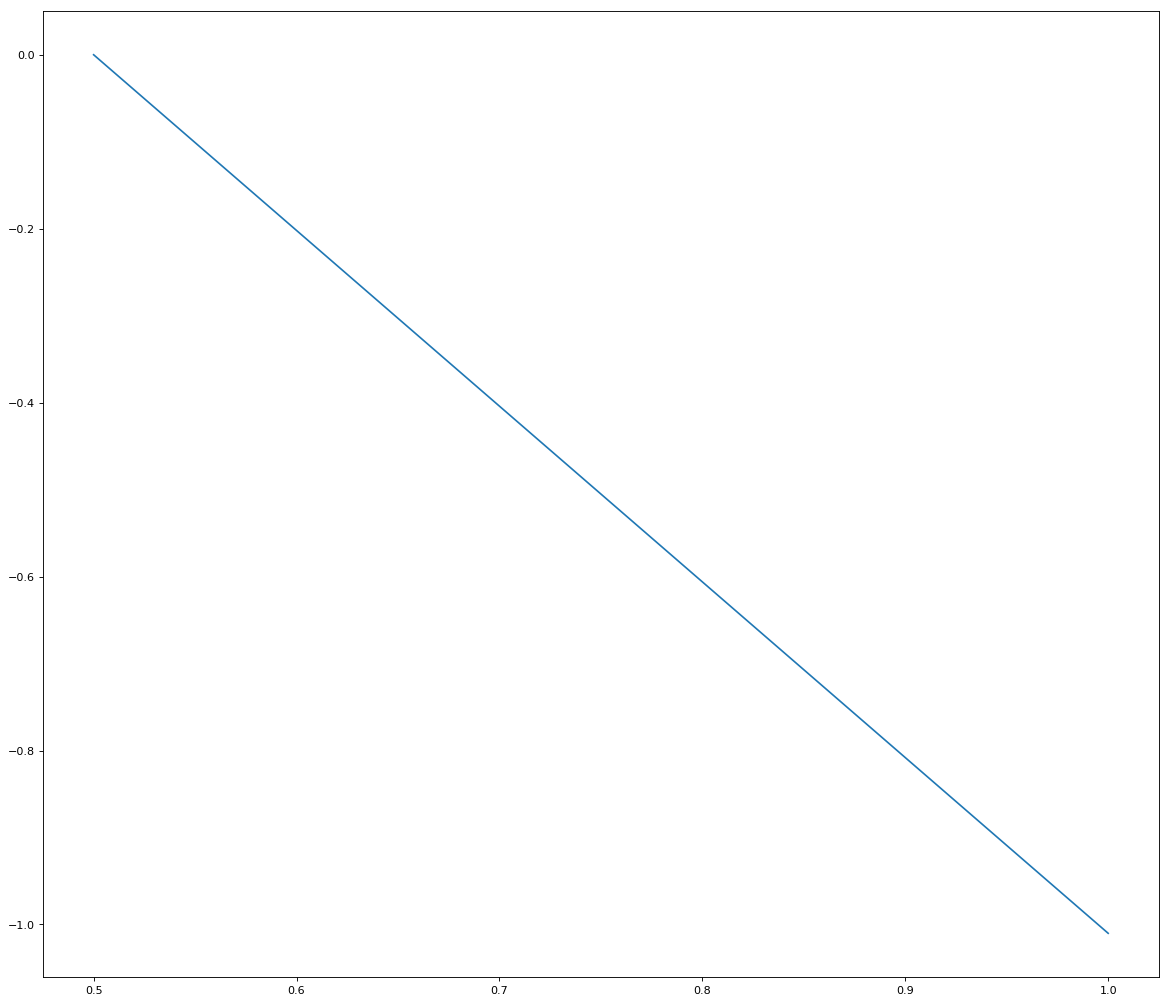

In [21]:
# plot solution
plt.figure()
bezier = domainExt2.sample('bezier', 9)
x, uExt2 = bezier.eval([ns.x, ns.uExt2])
#x, analytical = bezier.eval([ns.x, ns.analytical])
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x, uExt2)
#plt.plot(x, analytical, 'r')
# plt.ylim(-2,2)

## Solve primal problem

Build enriched basis at first

In [22]:
ns.basisPertTot  = domainTot.basis('discont', degree=degree)
perturbVect = []
ns.tempExt1 = ns.basisPertTot[:2]
perturbVect.append([ns.tempExt1[k] * lhsExt1[k] for k in range(0, len(ns.tempExt1))])
ns.tempInt = ns.basisPertTot[:]
perturbVect.append([ns.tempInt[k] * lhsInt[k] for k in range(0, len(ns.tempInt))])
ns.tempExt2 = ns.basisPertTot[2:]
perturbVect.append([ns.tempExt2[k] * lhsExt2[k] for k in range(0, len(ns.tempExt2))])

#pertBasis = []
#pertBasis.append([perturbVect[i][j] for i in range(0, len(perturbVect)) for j in range(0, len(perturbVect[i]))])

print(ns.basisTot)
print(type(ns.basisTot))
basisEnriched = [0, 0, 0]
testVect = []
for x in range(3):
    for turb in perturbVect[x]:
        basisEnriched[x] += turb
    testVect.append(basisEnriched[x])
    basisEnriched[x] = basisEnriched[x] + ns.basisTot[x]
ns.basisEnriched = basisEnriched
ns.testVect = testVect


ns.testVect = perturbVect[2]


Array<3>
<class 'nutils.function.Inflate'>


In [23]:
ns.x = geomTot

ns.bla0 = ns.basisEnriched[0]
ns.bla1 = ns.basisEnriched[1]
ns.bla2 = ns.basisEnriched[2]

/home/slukic/Coding/Python/nutils/nutils/warnings.py:30: NutilsWarning: using explicit inflation; this is usually a bug.
  warnings.warn(message, category, stacklevel=stacklevel)


<Figure size 432x288 with 0 Axes>

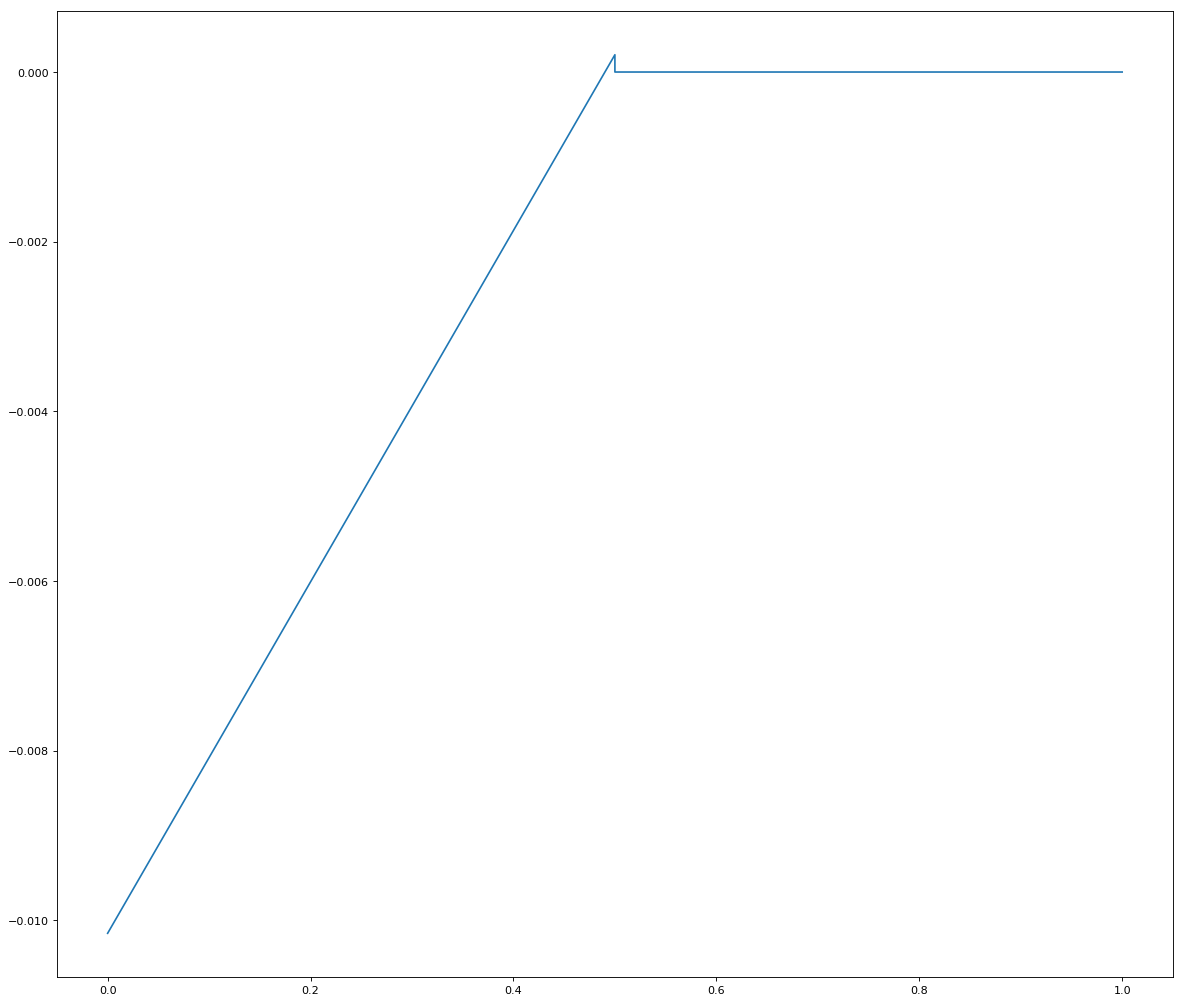

In [24]:

# plot solution
plt.figure()
bezier = domainTot.sample('bezier', 9)
x, bla0 = bezier.eval([ns.x, ns.bla0])
#x, analytical = bezier.eval([ns.x, ns.analytical])
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x, bla0)
#plt.plot(x, analytical, 'r')
# plt.ylim(-2,2)

/home/slukic/Coding/Python/nutils/nutils/warnings.py:30: NutilsWarning: using explicit inflation; this is usually a bug.
  warnings.warn(message, category, stacklevel=stacklevel)


<Figure size 432x288 with 0 Axes>

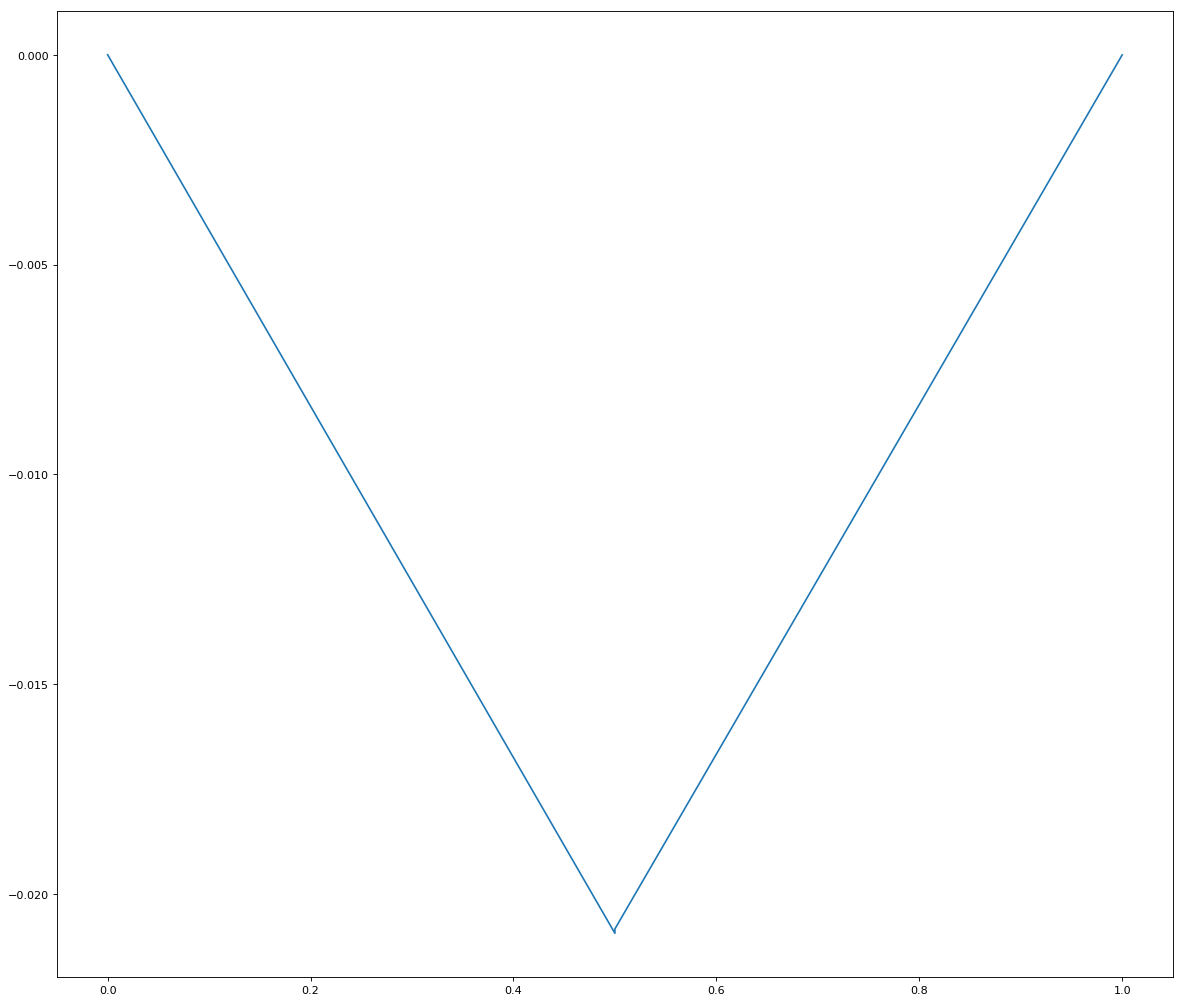

In [25]:
# plot solution
plt.figure()
bezier = domainTot.sample('bezier', 9)
x, bla1 = bezier.eval([ns.x, ns.bla1])
#x, analytical = bezier.eval([ns.x, ns.analytical])
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x, bla1)
#plt.plot(x, analytical, 'r')
# plt.ylim(-2,2)

/home/slukic/Coding/Python/nutils/nutils/warnings.py:30: NutilsWarning: using explicit inflation; this is usually a bug.
  warnings.warn(message, category, stacklevel=stacklevel)


<Figure size 432x288 with 0 Axes>

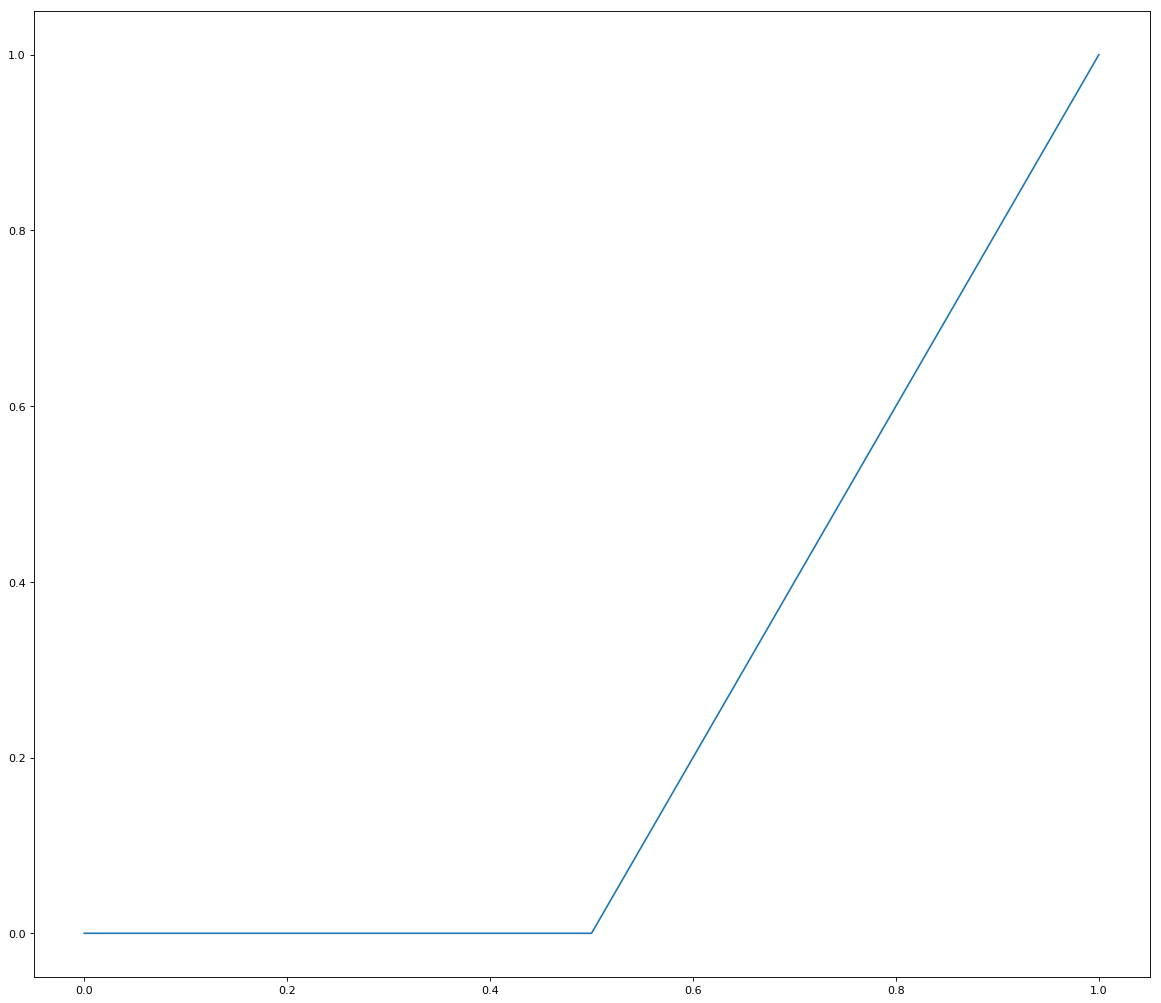

In [26]:
# plot solution
plt.figure()
bezier = domainTot.sample('bezier', 9)
x, bla2 = bezier.eval([ns.x, ns.bla2])
#x, analytical = bezier.eval([ns.x, ns.analytical])
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x, bla2)
#plt.plot(x, analytical, 'r')
# plt.ylim(-2,2)

## Solve primal problem

In [27]:
ns.x = geomTot

In [28]:
# construct residual
# Element integrals
# Diffusive part and RHS
res = domainTot.integral('k basisEnriched_n,0 u_,0 - basisEnriched_n f' @ ns, geometry=ns.x, degree=degree*2)
# Advective part
res += domainTot.integral('-v basisEnriched_n,0 u' @ ns, geometry=ns.x, degree=5)
# SUPG stabilized part
#res += domain.integral(' tau v basis_n,0 (v u_,0 - k (u_,0)_,0 - f )' @ ns, geometry=ns.x, degree=5)

# Interface integrals
# Diffusive part
#    part one                      |
#                                  v  minus might be necessary here because of jump definitions (likewise on second +)
#res += domainTot.interfaces.integral(' [basisEnriched_n] n_0 k {u_,0} + beta k {basisEnriched_n,0} [u] n_0' @ ns, geometry=ns.x, degree=degree*2)
#    part two (stabilized)
#res += domainTot.interfaces.integral(' tauA [basisEnriched_n] n_0 [u] n_0' @ ns, geometry=ns.x, degree=degree*2)
# Advective part
#res += domainTot.interfaces.integral('- v [basisEnriched_n] n_0 ({u} - .5 C [u] n_0)' @ ns, geometry=ns.x, degree=5)

# Boundary integrals LHS
#    part one
#res += domainTot.boundary.integral('- k basisEnriched_n u_,0 + beta k basisEnriched_n,0 u ' @ ns, geometry=ns.x, degree=degree*2)
#    part two (stabilized)
#res += domainTot.boundary['left'].integral(' tauZero basisEnriched_n u ' @ ns, geometry=ns.x, degree=degree*2)
#res += domainTot.boundary['right'].integral(' tauN basisEnriched_n u ' @ ns, geometry=ns.x, degree=degree*2)

# Boundary integrals RHS (weakly imposed boundary conditions) (including stabilization)
# Diffusive part
#res -= domainTot.boundary['left'].integral(' ( beta k basisEnriched_n,0 + tauZero basisEnriched_n) gl ' @ ns, geometry=ns.x, degree=degree*2)
#res -= domainTot.boundary['right'].integral(' ( beta k basisEnriched_n,0 + tauN basisEnriched_n) gr ' @ ns, geometry=ns.x, degree=degree*2)
# Advective part
#res += domainTot.boundary['left'].integral('v basisEnriched_n n_0 (0.5 (gl + u) - .5 C (gl - u) n_0)' @ ns, geometry=ns.x, degree=degree*2)
#res += domainTot.boundary['right'].integral('v basisEnriched_n n_0 (0.5 (gr + u) - .5 C (gr - u) n_0)' @ ns, geometry=ns.x, degree=degree*2)

In [29]:
sqr = domainTot.boundary['left'].integral('(u - gl)^2' @ ns, geometry=ns.x, degree=degree*2)
sqr += domainTot.boundary['right'].integral('(u - gr)^2' @ ns, geometry=ns.x, degree=degree*2)
cons = solver.optimize('lhs', sqr, droptol=1e-15)

optimize > iter 1 > solve > solver returned with residual 0e+00
optimize > constrained 2/3 dofs


In [30]:
# find lhs such that res == 0 and substitute this lhs in the namespace
lhs = solver.solve_linear('lhs', res, constrain=cons)
#lhs = solver.solve_linear('lhs', res)
ns = ns(lhs=lhs)

Here comes the Jacobian
(3, 3)
[[ 2. -2.  0.]
 [-2.  4. -2.]
 [ 0. -2.  2.]]
[ 0.  0.  0.]
solve > solver returned with residual 0e+00


/home/slukic/Coding/Python/nutils/nutils/warnings.py:30: NutilsWarning: using explicit inflation; this is usually a bug.
  warnings.warn(message, category, stacklevel=stacklevel)


<Figure size 432x288 with 0 Axes>

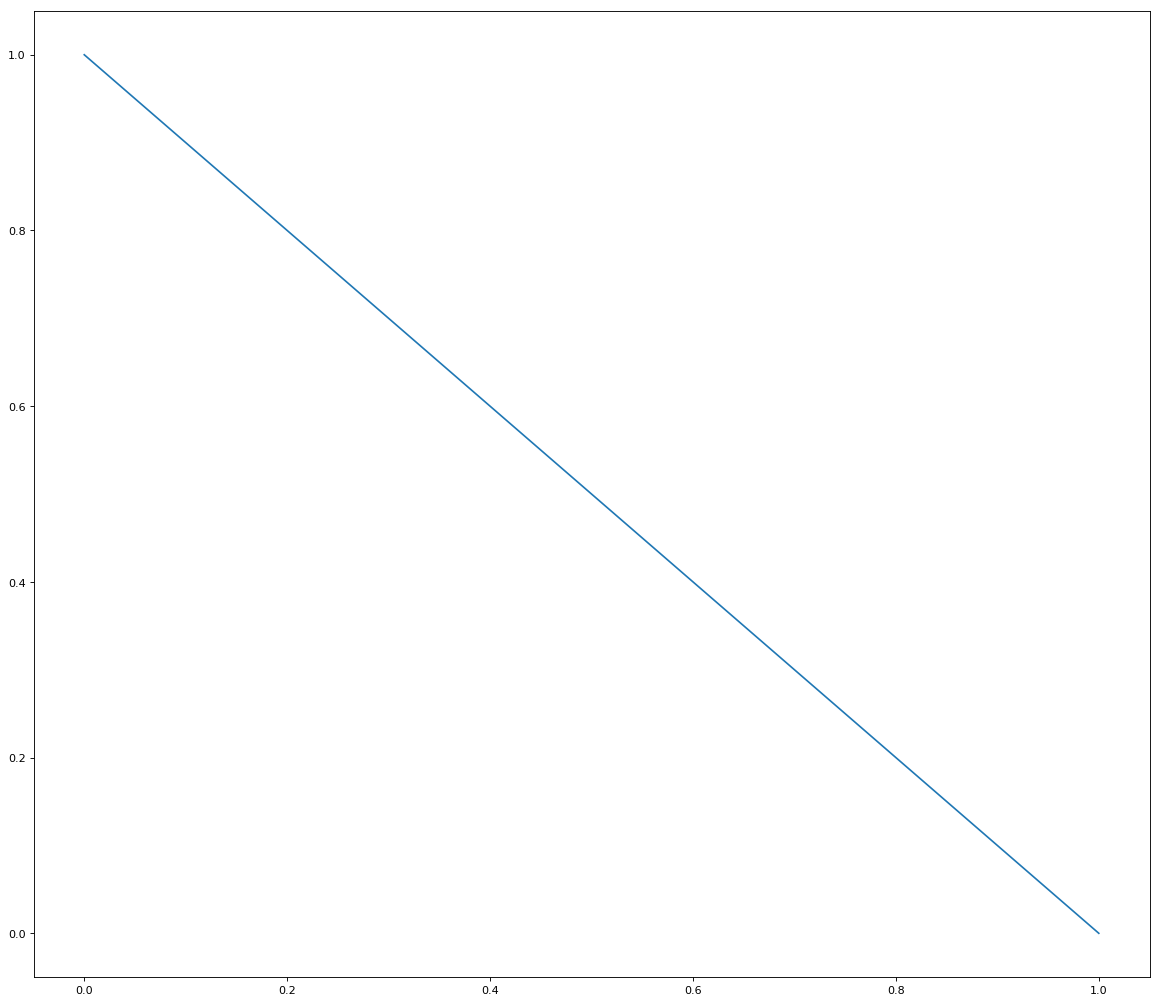

In [31]:
# plot solution
plt.figure()
bezier = domainTot.sample('bezier', 9)
x, u = bezier.eval([ns.x, ns.u])
#x, analytical = bezier.eval([ns.x, ns.analytical])
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x, u)
#plt.plot(x, analytical, 'r')
# plt.ylim(-2,2)